# Analyse de réseaux


Version du 15 mai 2022


* [Théorie (mathématique) des graphes](https://fr.wikipedia.org/wiki/Th%C3%A9orie_des_graphes) (Wikipedia)
* [Analyse des réseaux sociaux](https://fr.wikipedia.org/wiki/Analyse_des_r%C3%A9seaux_sociaux) (Wikipedia)
* Jacques Cellier / Martine Cocaud, _Le traitement des données en histoire et sciences sociales : méthodes et outils_, Rennes: Presses univ. de Rennes, 2012. 
  * Partie IV, Chapitres 11-15 : "Analyse des réseaux sociaux"
  * [Site du livre mettant à disposition les données utilisées](http://jacquescellier.fr/histoire/site_tdh2/)
* Wouter de Nooy / Andrej Mrvar / Vladimir Batagelj, _Exploratory Social Network Analysis with Pajek_, Third edition, Cambridge: Cambridge University Press, 2018.  

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
# https://networkx.org/documentation/stable/install.html
import networkx as nx

#### https://ipycytoscape.readthedocs.io/en/latest/installing.html
# import ipycytoscape as cy

In [3]:
from shutil import copyfile
import csv
import itertools

## Définitions

* Un graphe est un ensemble de sommets ou noeuds (_vertices_ ou _nodes_) reliés par des relations
* Si les relations sont symétriques (par ex., la personne A discute avec la personne B) le graphe est non orienté (_undirected_), sinon le graphe est dit orienté (_directed_) (par ex., A préfère B parmi ses amies)
* Dans le cas d'un graphe orienté, les relations sont des fléches ou arcs (_arrow_ ou _arc_), sinon on parle de arêtes (_edges_)

## Ouvrir et explorer un graphe existant

In [43]:
### Ouvrir un document au format Pajek
#  On reconnaît le format Payek du graphe par le suffixe .net 

# https://networkx.org/documentation/stable/reference/readwrite/generated/networkx.readwrite.pajek.read_pajek.html

## inspecter préalablement le fichier dans un éditeur de texte : edges = undirected

##  Format du graphe:
# http://vladowiki.fmf.uni-lj.si/doku.php?id=pajek:faq:format

# cette fonction ne dispose pas de paramètre en entrée, sauf l'adresse du fichier au format Pajek

PK = nx.read_pajek('../manuels/cellier_cocaud_chap_11-15/florence.net')


In [44]:
### Le résultat de la fonction est un MultiGraph :

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/multigraph.html

print(type(PK))


<class 'networkx.classes.multigraph.MultiGraph'>


In [45]:
### Inspecter le graphe 
## s'il est suffisamment petit ! Ici il a 15 nodes
# sinon mettre des limites comme indiqué ci-dessus, 
# grâce à la méthode 'slicing' de liste
print(list(PK.nodes.data())[:5])
print('-----')
## Noter le dernier doublon de relations
print(list(PK.edges.data())[-5:])

[('ACCIAIUOLI', {'id': '1'}), ('ALBIZZI', {'id': '2'}), ('BARBADORI', {'id': '3'}), ('BISCHERI', {'id': '4'}), ('CASTELLANI', {'id': '5'})]
-----
[('PERUZZI', 'STROZZI', {}), ('RIDOLFI', 'STROZZI', {}), ('RIDOLFI', 'TORNABUONI', {}), ('RIDOLFI', 'TORNABUONI', {}), ('STROZZI', 'STROZZI', {})]


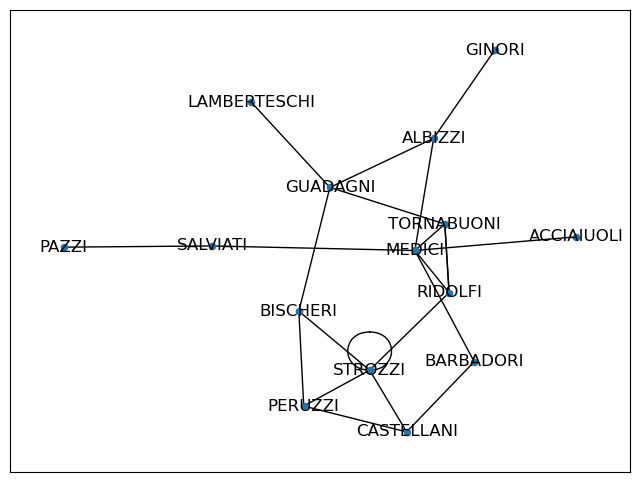

In [46]:
### Un premier affichage (ne marche que avec peu de sommets)

# l'algorithme cherche la meilleure position des somments
# si on exécute plurieurs fois l'apparence peut changer

plt.figure(figsize = (8,6))
nx.draw_networkx(PK, node_size = 20)

In [47]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

PK.is_multigraph(), PK.is_directed(), PK.number_of_nodes(), PK.number_of_edges(), nx.is_connected(PK), nx.density(PK)

(True, False, 15, 22, True, 0.20952380952380953)

In [48]:
### Y a-t-il des loops ? Un sommet en relation avec lui même ?
# https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.nodes_with_selfloops.html
list(nx.nodes_with_selfloops(PK))

['STROZZI']

In [49]:
### Compter et inspecter les loops
len(list(nx.selfloop_edges(PK))), list(nx.selfloop_edges(PK))[:3]

(1, [('STROZZI', 'STROZZI')])

In [50]:
### Éliminer les selfloops
PK.remove_edges_from(nx.selfloop_edges(PK))

In [51]:
### Compter et inspecter les loops
len(list(nx.selfloop_edges(PK))), list(nx.selfloop_edges(PK))[:3]

(0, [])

### Nettoyer le graphe original (format Pajek .net)

In [52]:
### Create an undirected graph of your multigraph where multiple edges are merged into single edges
# weight
G = nx.Graph(PK)
print(type(G))


<class 'networkx.classes.graph.Graph'>


In [53]:
### Regrouper et compter les edges, ou récupérer les poids et autres attributs
#  https://stackoverflow.com/questions/15590812/networkx-convert-multigraph-into-simple-graph-with-weighted-edges

G = nx.Graph()
for u,v,data in PK.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if G.has_edge(u,v):
        G[u][v]['weight'] += w
    else:
        G.add_edge(u, v, weight=w)
        
print(list(G.edges(data=True))[:10])

[('ACCIAIUOLI', 'MEDICI', {'weight': 1.0}), ('MEDICI', 'ALBIZZI', {'weight': 1.0}), ('MEDICI', 'BARBADORI', {'weight': 1.0}), ('MEDICI', 'RIDOLFI', {'weight': 1.0}), ('MEDICI', 'SALVIATI', {'weight': 1.0}), ('MEDICI', 'TORNABUONI', {'weight': 1.0}), ('ALBIZZI', 'GINORI', {'weight': 1.0}), ('ALBIZZI', 'GUADAGNI', {'weight': 1.0}), ('GUADAGNI', 'BISCHERI', {'weight': 1.0}), ('GUADAGNI', 'LAMBERTESCHI', {'weight': 1.0})]


In [54]:
[i[2] for i in list(G.edges.data())][-3:]

[{'weight': 1.0}, {'weight': 2.0}, {'weight': 1.0}]

In [55]:
### Chercher les arêtes qui étaient multiples

[i for i in list(G.edges.data()) if i[2]['weight'] > 1]

[('TORNABUONI', 'RIDOLFI', {'weight': 2.0})]

In [56]:
G.is_multigraph()

False

In [57]:
### Eliminer les 'id' du format .net de Pajek (qui risquent de déranger)
# et transformer en graphe simple (agréger les lignes multiples)

# liste des noeuds ou sommets
e = G.nodes()
pop = [G.nodes[n].pop('id',None) for n in e]

In [58]:
## Inspecter le résultat, les attributs ou propriétés 'id' ont disparu
# Noter que les noms font fonction d'identifiant
print(G.nodes.data())
print('-----')
print(G.edges.data())

[('ACCIAIUOLI', {}), ('MEDICI', {}), ('ALBIZZI', {}), ('GINORI', {}), ('GUADAGNI', {}), ('BARBADORI', {}), ('CASTELLANI', {}), ('BISCHERI', {}), ('PERUZZI', {}), ('STROZZI', {}), ('LAMBERTESCHI', {}), ('TORNABUONI', {}), ('RIDOLFI', {}), ('SALVIATI', {}), ('PAZZI', {})]
-----
[('ACCIAIUOLI', 'MEDICI', {'weight': 1.0}), ('MEDICI', 'ALBIZZI', {'weight': 1.0}), ('MEDICI', 'BARBADORI', {'weight': 1.0}), ('MEDICI', 'RIDOLFI', {'weight': 1.0}), ('MEDICI', 'SALVIATI', {'weight': 1.0}), ('MEDICI', 'TORNABUONI', {'weight': 1.0}), ('ALBIZZI', 'GINORI', {'weight': 1.0}), ('ALBIZZI', 'GUADAGNI', {'weight': 1.0}), ('GUADAGNI', 'BISCHERI', {'weight': 1.0}), ('GUADAGNI', 'LAMBERTESCHI', {'weight': 1.0}), ('GUADAGNI', 'TORNABUONI', {'weight': 1.0}), ('BARBADORI', 'CASTELLANI', {'weight': 1.0}), ('CASTELLANI', 'PERUZZI', {'weight': 1.0}), ('CASTELLANI', 'STROZZI', {'weight': 1.0}), ('BISCHERI', 'PERUZZI', {'weight': 1.0}), ('BISCHERI', 'STROZZI', {'weight': 1.0}), ('PERUZZI', 'STROZZI', {'weight': 1.0}

In [59]:
### En analyse de réseaux on travaille avec des matrices: 
#  transformer en matrice — au format DataFrame Pandas
#  https://networkx.org/documentation/stable/reference/convert.html

## Modifier l'affichage des décimaux,le formatage, pour ne voir que les entiers
pd.options.display.float_format = '{: .0f}'.format
## Retour à affichage par défaut:
#pd.options.display.float_format = '{: }'.format  # : 4f


nx.to_pandas_adjacency(G)

,ACCIAIUOLI,MEDICI,ALBIZZI,GINORI,GUADAGNI,BARBADORI,CASTELLANI,BISCHERI,PERUZZI,STROZZI,LAMBERTESCHI,TORNABUONI,RIDOLFI,SALVIATI,PAZZI
ACCIAIUOLI,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
MEDICI,1,0,1,0,0,1,0,0,0,0,0,1,1,1,0
ALBIZZI,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0
GINORI,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
GUADAGNI,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0
BARBADORI,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
CASTELLANI,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0
BISCHERI,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0
PERUZZI,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0
STROZZI,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0


### Modifier le _layout_ pour l'affichage

Documentation: [référence pour l'affichage des réseaux](https://networkx.org/documentation/stable/reference/drawing.html)

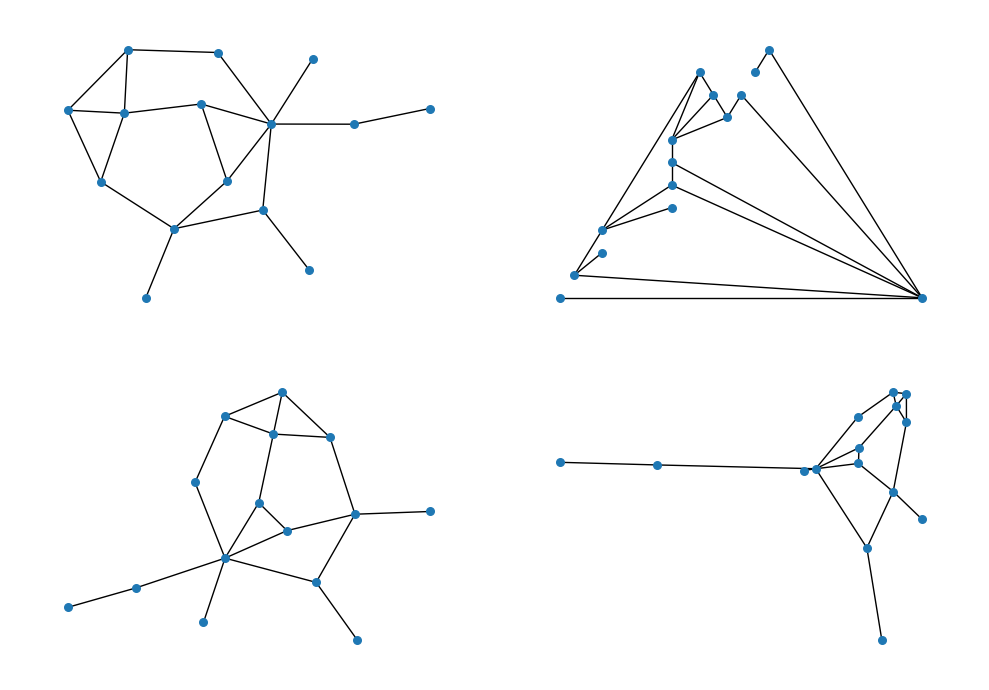

In [60]:
###  https://networkx.org/documentation/stable/auto_examples/drawing/plot_four_grids.htmlfig, all_axes = plt.subplots(2, 2)
# https://www.statology.org/subplot-size-matplotlib/

fig, all_axes = plt.subplots(2, 2, figsize=(10,7))

ax = all_axes.flat

pos0 = nx.kamada_kawai_layout(G)
pos1 = nx.planar_layout(G)
pos2 = nx.spring_layout(G)
pos3 = nx.spectral_layout(G)

nx.draw(G, pos0, ax=ax[0], node_size=30)
nx.draw(G, pos1, ax=ax[1], node_size=30)
nx.draw(G, pos2, ax=ax[2], node_size=30)
nx.draw(G, pos3, ax=ax[3], node_size=30)

for a in ax:
    a.margins(0.10)
fig.tight_layout()
fig.figure.figsize=[20,10]

plt.show()

{'ACCIAIUOLI': array([0.43664839, 0.45954378]), 'MEDICI': array([0.23852047, 0.1226863 ]), 'ALBIZZI': array([ 0.19723508, -0.32385271]), 'GINORI': array([ 0.42205397, -0.6367957 ]), 'GUADAGNI': array([-0.22963462, -0.42084637]), 'BARBADORI': array([-0.01927602,  0.49410923]), 'CASTELLANI': array([-0.45261557,  0.50874324]), 'BISCHERI': array([-0.58220136, -0.17691468]), 'PERUZZI': array([-0.7400879 ,  0.19445049]), 'STROZZI': array([-0.46837781,  0.17914946]), 'LAMBERTESCHI': array([-0.36538217, -0.7794654 ]), 'TORNABUONI': array([ 0.02581077, -0.17282861]), 'RIDOLFI': array([-0.09857709,  0.22680239]), 'SALVIATI': array([0.63588386, 0.12193674]), 'PAZZI': array([1.        , 0.20328184])}


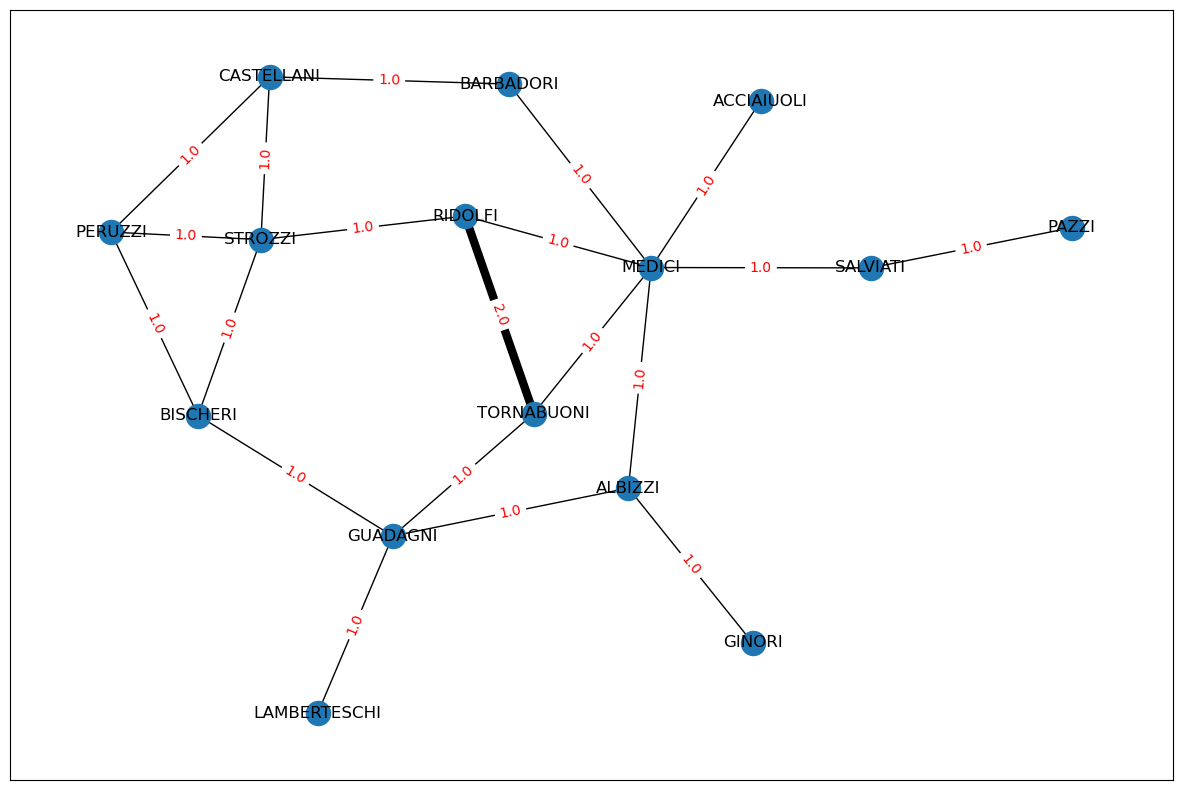

In [61]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,10))

### https://networkx.org/documentation/stable/auto_examples/drawing/plot_weighted_graph.html
edges_weight = [i[2]['weight']*3 if i[2]['weight'] > 1 else i[2]['weight'] for i in list(G.edges.data())]

#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)
print(pos)


nx.draw_networkx(G, pos, width = edges_weight)

### https://stackoverflow.com/questions/57421372/display-edge-weights-on-networkx-graph
labels = {e: G.edges[e]['weight'] for e in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels = labels, font_color='red')

pd.options.display.float_format = '{: .0f}'.format

# Enregistrer un export jpg
plt.savefig("graphs/G_draw_networkx.jpg", format="jpg")
plt.show()

## Ajouter des attributs aux sommets

In [62]:
### Créer un DataFrame contenant le fichier CSV mis à disposition, 
#  contenant les attributs ou propriétés des sommets 
#  Attention à indiquer que la colonne 'id' doit être l'index du DataFrame
attributes = pd.read_csv('../manuels/cellier_cocaud_chap_11-15/florencesarttributs.csv', sep= ';', index_col= 'id')
attributes

,Parti,Revenus,Sieges
id,,,
ACCIAIUOLI,MED,10,53
ALBIZZI,OLI,36,65
BARBADORI,GIR,55,0
BISCHERI,OLI,44,12
CASTELLANI,OLI,20,22
GINORI,MED,32,0
GUADAGNI,OLI,8,21
LAMBERTESCHI,OLI,42,0
MEDICI,MED,103,53


In [63]:
### Avant d'ajouter les attributs au graphe, 
#  créer un dictionnaire ayant pour clé l'index du DataFrame

#  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_dict.html
dict_attr = attributes.to_dict('index')
print(dict_attr)

{'ACCIAIUOLI': {'Parti': 'MED', 'Revenus': 10, 'Sieges': 53}, 'ALBIZZI': {'Parti': 'OLI', 'Revenus': 36, 'Sieges': 65}, 'BARBADORI': {'Parti': 'GIR', 'Revenus': 55, 'Sieges': 0}, 'BISCHERI': {'Parti': 'OLI', 'Revenus': 44, 'Sieges': 12}, 'CASTELLANI': {'Parti': 'OLI', 'Revenus': 20, 'Sieges': 22}, 'GINORI': {'Parti': 'MED', 'Revenus': 32, 'Sieges': 0}, 'GUADAGNI': {'Parti': 'OLI', 'Revenus': 8, 'Sieges': 21}, 'LAMBERTESCHI': {'Parti': 'OLI', 'Revenus': 42, 'Sieges': 0}, 'MEDICI': {'Parti': 'MED', 'Revenus': 103, 'Sieges': 53}, 'PAZZI': {'Parti': 'GIR', 'Revenus': 48, 'Sieges': 0}, 'PERUZZI': {'Parti': 'OLI', 'Revenus': 49, 'Sieges': 42}, 'RIDOLFI': {'Parti': 'MED', 'Revenus': 27, 'Sieges': 38}, 'SALVIATI': {'Parti': 'MED', 'Revenus': 10, 'Sieges': 35}, 'STROZZI': {'Parti': 'OLI', 'Revenus': 146, 'Sieges': 74}, 'TORNABUONI': {'Parti': 'MED', 'Revenus': 48, 'Sieges': 0}}


In [64]:
###  Ajouter les attributs
#  La clé de jointure est l'id du dictionnaire premier niveau – l'id du sommet:
#  Il s'agit donc du nom majuscule dans ce cas
#  https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.set_node_attributes.html

nx.set_node_attributes(G, dict_attr)

# inspecter les sommets et leurs attributs
list(G.nodes.data())

[('ACCIAIUOLI', {'Parti': 'MED', 'Revenus': 10, 'Sieges': 53}),
 ('MEDICI', {'Parti': 'MED', 'Revenus': 103, 'Sieges': 53}),
 ('ALBIZZI', {'Parti': 'OLI', 'Revenus': 36, 'Sieges': 65}),
 ('GINORI', {'Parti': 'MED', 'Revenus': 32, 'Sieges': 0}),
 ('GUADAGNI', {'Parti': 'OLI', 'Revenus': 8, 'Sieges': 21}),
 ('BARBADORI', {'Parti': 'GIR', 'Revenus': 55, 'Sieges': 0}),
 ('CASTELLANI', {'Parti': 'OLI', 'Revenus': 20, 'Sieges': 22}),
 ('BISCHERI', {'Parti': 'OLI', 'Revenus': 44, 'Sieges': 12}),
 ('PERUZZI', {'Parti': 'OLI', 'Revenus': 49, 'Sieges': 42}),
 ('STROZZI', {'Parti': 'OLI', 'Revenus': 146, 'Sieges': 74}),
 ('LAMBERTESCHI', {'Parti': 'OLI', 'Revenus': 42, 'Sieges': 0}),
 ('TORNABUONI', {'Parti': 'MED', 'Revenus': 48, 'Sieges': 0}),
 ('RIDOLFI', {'Parti': 'MED', 'Revenus': 27, 'Sieges': 38}),
 ('SALVIATI', {'Parti': 'MED', 'Revenus': 10, 'Sieges': 35}),
 ('PAZZI', {'Parti': 'GIR', 'Revenus': 48, 'Sieges': 0})]

### Afficher en fonction des attributs

In [80]:
### Adapter la taille des attribut à l'affichage
revenus = [i[1]['Revenus'] for i in list(G.nodes.data())]
print(sorted(revenus))
node_sizes = [i**2 for i in revenus]
sorted(node_sizes)

[8, 10, 10, 20, 27, 32, 36, 42, 44, 48, 48, 49, 55, 103, 146]


[64,
 100,
 100,
 400,
 729,
 1024,
 1296,
 1764,
 1936,
 2304,
 2304,
 2401,
 3025,
 10609,
 21316]

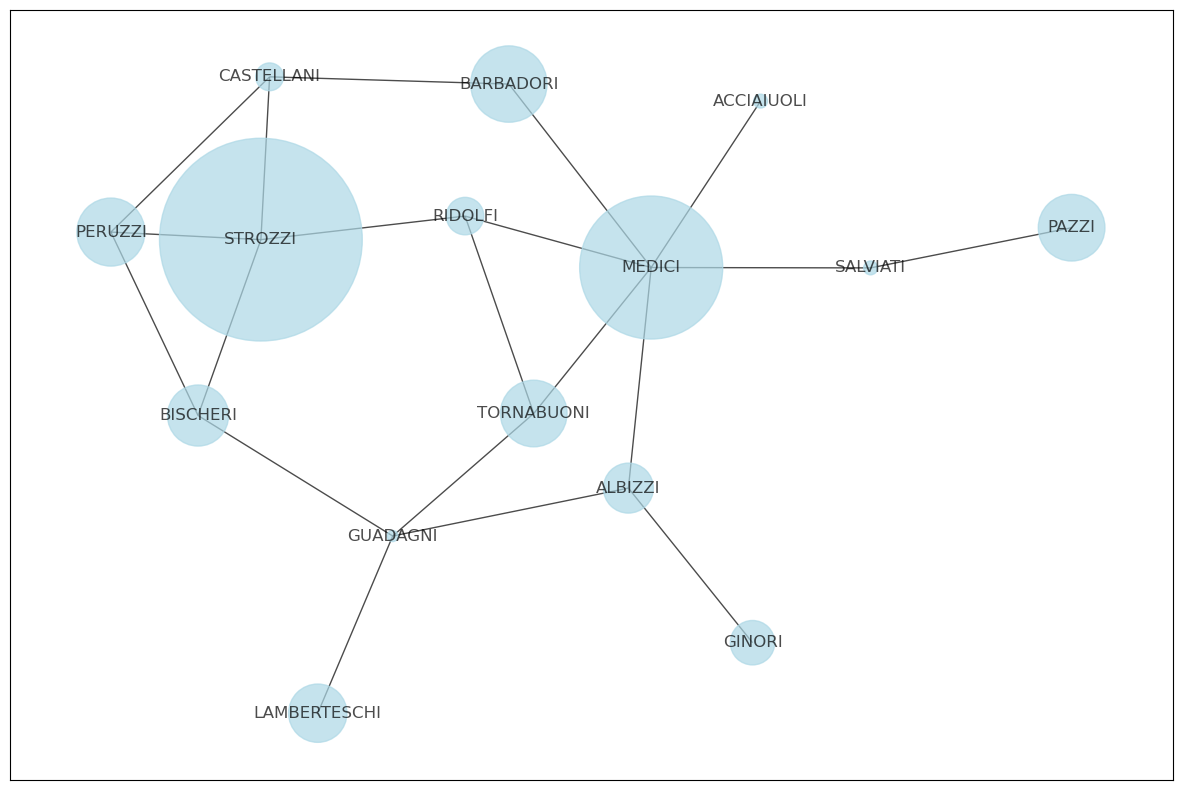

In [82]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,10))

#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)

## la surface est proportionnelle au carré de l'effectif, comparer avec node_size=revenus
nx.draw_networkx(G, pos, node_size=node_sizes, node_color='LightBlue', alpha=0.7)

## Une nouvelle information : les familles les plus riches se trouvent au centre du réseau
#  Ce n'est pas nécessairement le cas

## Ajouter les paramètres de centralité

Noter que les fonctions produisent des résultats avec des formats différents, qu'il s'agira de traiter

### Centralité de degré

Documentation: [degree_centrality(G)](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality)

In [83]:
### Noter le résultat de la fonction
print(nx.degree(G))
print('----')
### l'ajout d'une propriété doit se faire sous la forme de dictionnaire
# On construit ici le dictionnaire selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(G)])
print(degree)

[('ACCIAIUOLI', 1), ('MEDICI', 6), ('ALBIZZI', 3), ('GINORI', 1), ('GUADAGNI', 4), ('BARBADORI', 2), ('CASTELLANI', 3), ('BISCHERI', 3), ('PERUZZI', 3), ('STROZZI', 4), ('LAMBERTESCHI', 1), ('TORNABUONI', 3), ('RIDOLFI', 3), ('SALVIATI', 2), ('PAZZI', 1)]
----
{'ACCIAIUOLI': {'degree': 1}, 'MEDICI': {'degree': 6}, 'ALBIZZI': {'degree': 3}, 'GINORI': {'degree': 1}, 'GUADAGNI': {'degree': 4}, 'BARBADORI': {'degree': 2}, 'CASTELLANI': {'degree': 3}, 'BISCHERI': {'degree': 3}, 'PERUZZI': {'degree': 3}, 'STROZZI': {'degree': 4}, 'LAMBERTESCHI': {'degree': 1}, 'TORNABUONI': {'degree': 3}, 'RIDOLFI': {'degree': 3}, 'SALVIATI': {'degree': 2}, 'PAZZI': {'degree': 1}}


In [84]:
nx.set_node_attributes(G, degree)
print(list(G.nodes.data())[:3])

[('ACCIAIUOLI', {'Parti': 'MED', 'Revenus': 10, 'Sieges': 53, 'degree': 1}), ('MEDICI', {'Parti': 'MED', 'Revenus': 103, 'Sieges': 53, 'degree': 6}), ('ALBIZZI', {'Parti': 'OLI', 'Revenus': 36, 'Sieges': 65, 'degree': 3})]


### Centralité de proximité

Compute [closeness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality) for nodes.


In [85]:
print(nx.closeness_centrality(G))
closeness = nx.closeness_centrality(G)

{'ACCIAIUOLI': 0.3684210526315789, 'MEDICI': 0.56, 'ALBIZZI': 0.4827586206896552, 'GINORI': 0.3333333333333333, 'GUADAGNI': 0.4666666666666667, 'BARBADORI': 0.4375, 'CASTELLANI': 0.3888888888888889, 'BISCHERI': 0.4, 'PERUZZI': 0.3684210526315789, 'STROZZI': 0.4375, 'LAMBERTESCHI': 0.32558139534883723, 'TORNABUONI': 0.4827586206896552, 'RIDOLFI': 0.5, 'SALVIATI': 0.3888888888888889, 'PAZZI': 0.2857142857142857}


In [86]:
nx.set_node_attributes(G, closeness, 'closeness')
# print(G.nodes.data())

### Centralité d'intermédiarité

[Betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality)

In [87]:
print(nx.betweenness_centrality(G))
betweenness = nx.betweenness_centrality(G)

{'ACCIAIUOLI': 0.0, 'MEDICI': 0.521978021978022, 'ALBIZZI': 0.2124542124542125, 'GINORI': 0.0, 'GUADAGNI': 0.25457875457875456, 'BARBADORI': 0.09340659340659341, 'CASTELLANI': 0.05494505494505495, 'BISCHERI': 0.1043956043956044, 'PERUZZI': 0.02197802197802198, 'STROZZI': 0.10256410256410256, 'LAMBERTESCHI': 0.0, 'TORNABUONI': 0.09157509157509158, 'RIDOLFI': 0.11355311355311355, 'SALVIATI': 0.14285714285714288, 'PAZZI': 0.0}


In [88]:
nx.set_node_attributes(G, betweenness, 'betweenness')
print(list(G.nodes.data())[:3])

[('ACCIAIUOLI', {'Parti': 'MED', 'Revenus': 10, 'Sieges': 53, 'degree': 1, 'closeness': 0.3684210526315789, 'betweenness': 0.0}), ('MEDICI', {'Parti': 'MED', 'Revenus': 103, 'Sieges': 53, 'degree': 6, 'closeness': 0.56, 'betweenness': 0.521978021978022}), ('ALBIZZI', {'Parti': 'OLI', 'Revenus': 36, 'Sieges': 65, 'degree': 3, 'closeness': 0.4827586206896552, 'betweenness': 0.2124542124542125})]


### Centralité d'influence ou de pouvoir (_eigenvector_)

[Eigenvector centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html#networkx.algorithms.centrality.eigenvector_centrality)


In [89]:
print(nx.eigenvector_centrality(G))
eigenvector = nx.eigenvector_centrality(G)

{'ACCIAIUOLI': 0.13215731952853418, 'MEDICI': 0.4303154258349922, 'ALBIZZI': 0.2439605296754477, 'GINORI': 0.0749245316027793, 'GUADAGNI': 0.2891171573226501, 'BARBADORI': 0.21170574706479847, 'CASTELLANI': 0.2590200378423514, 'BISCHERI': 0.2827943958713356, 'PERUZZI': 0.2757224374104833, 'STROZZI': 0.355973032646045, 'LAMBERTESCHI': 0.08879253113499548, 'TORNABUONI': 0.32584670416957395, 'RIDOLFI': 0.34155442590743645, 'SALVIATI': 0.1459208416417183, 'PAZZI': 0.04481493970386308}


In [90]:
nx.set_node_attributes(G, eigenvector, 'eigenvector')
print(list(G.nodes.data())[:3])

[('ACCIAIUOLI', {'Parti': 'MED', 'Revenus': 10, 'Sieges': 53, 'degree': 1, 'closeness': 0.3684210526315789, 'betweenness': 0.0, 'eigenvector': 0.13215731952853418}), ('MEDICI', {'Parti': 'MED', 'Revenus': 103, 'Sieges': 53, 'degree': 6, 'closeness': 0.56, 'betweenness': 0.521978021978022, 'eigenvector': 0.4303154258349922}), ('ALBIZZI', {'Parti': 'OLI', 'Revenus': 36, 'Sieges': 65, 'degree': 3, 'closeness': 0.4827586206896552, 'betweenness': 0.2124542124542125, 'eigenvector': 0.2439605296754477})]


## Exporter les attributs pour les explorer 

In [91]:
### Exporter les attributs vers un DataFrame afin de les explorer
export = pd.DataFrame(G.nodes.data(), columns = ['id', 'attributes'])
export

,id,attributes
0,ACCIAIUOLI,"{'Parti': 'MED', 'Revenus': 10, 'Sieges': 53, ..."
1,MEDICI,"{'Parti': 'MED', 'Revenus': 103, 'Sieges': 53,..."
2,ALBIZZI,"{'Parti': 'OLI', 'Revenus': 36, 'Sieges': 65, ..."
3,GINORI,"{'Parti': 'MED', 'Revenus': 32, 'Sieges': 0, '..."
4,GUADAGNI,"{'Parti': 'OLI', 'Revenus': 8, 'Sieges': 21, '..."
5,BARBADORI,"{'Parti': 'GIR', 'Revenus': 55, 'Sieges': 0, '..."
6,CASTELLANI,"{'Parti': 'OLI', 'Revenus': 20, 'Sieges': 22, ..."
7,BISCHERI,"{'Parti': 'OLI', 'Revenus': 44, 'Sieges': 12, ..."
8,PERUZZI,"{'Parti': 'OLI', 'Revenus': 49, 'Sieges': 42, ..."
9,STROZZI,"{'Parti': 'OLI', 'Revenus': 146, 'Sieges': 74,..."


In [92]:
### Décomposer le champs attributs en colonnes
# https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas

attributes = pd.json_normalize(export.attributes)

## Retour à affichage des décimales par défaut:
pd.options.display.float_format = '{: }'.format  # pour 4 chiffres : 4f

round(attributes, 3)

,Parti,Revenus,Sieges,degree,closeness,betweenness,eigenvector
0,MED,10,53,1,0.368,0.0,0.132
1,MED,103,53,6,0.56,0.522,0.43
2,OLI,36,65,3,0.483,0.212,0.244
3,MED,32,0,1,0.333,0.0,0.075
4,OLI,8,21,4,0.467,0.255,0.289
5,GIR,55,0,2,0.438,0.093,0.212
6,OLI,20,22,3,0.389,0.055,0.259
7,OLI,44,12,3,0.4,0.104,0.283
8,OLI,49,42,3,0.368,0.022,0.276
9,OLI,146,74,4,0.438,0.103,0.356


In [93]:
### appliquer au DataFrame et supprimer la colonne attributes
# en même temps mettre le nom en index
export = export.join(pd.json_normalize(export.attributes)).set_index('id')
export.drop(columns=['attributes'], inplace=True)

In [94]:
round(export.sort_values(by=['eigenvector'], ascending=False),3)

,Parti,Revenus,Sieges,degree,closeness,betweenness,eigenvector
id,,,,,,,
MEDICI,MED,103,53,6,0.56,0.522,0.43
STROZZI,OLI,146,74,4,0.438,0.103,0.356
RIDOLFI,MED,27,38,3,0.5,0.114,0.342
TORNABUONI,MED,48,0,3,0.483,0.092,0.326
GUADAGNI,OLI,8,21,4,0.467,0.255,0.289
BISCHERI,OLI,44,12,3,0.4,0.104,0.283
PERUZZI,OLI,49,42,3,0.368,0.022,0.276
CASTELLANI,OLI,20,22,3,0.389,0.055,0.259
ALBIZZI,OLI,36,65,3,0.483,0.212,0.244


## Explorer les relations entre propriétés structurales (centralités) et/ou attributs

### Relations entre deux centralités

In [ ]:
degree = export.degree
closeness = export.closeness
betweenness = export.betweenness
eigenvector = export.eigenvector
revenus = export.Revenus
sieges = export.Sieges

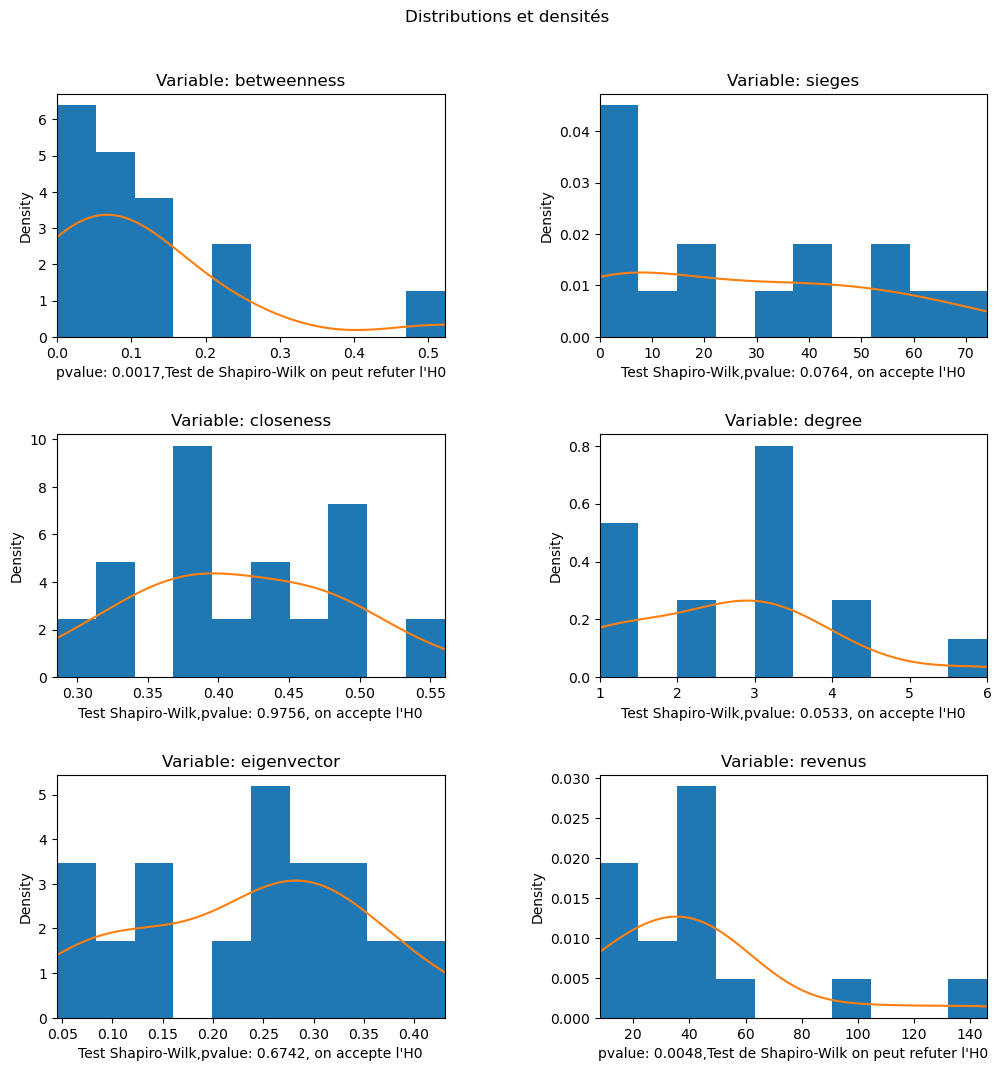

In [124]:
## https://engineeringfordatascience.com/posts/matplotlib_subplots/
plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.suptitle("Distributions et densités", fontsize=12, y=0.95)


df_app = pd.DataFrame(list(zip(betweenness, sieges, closeness, degree, eigenvector, revenus)))
df_app.columns=['betweenness', 'sieges', 'closeness', 'degree', 'eigenvector', 'revenus']
e = df_app.columns

# loop through the length of tickers and keep track of index
for n, e in enumerate(e):
    # add a new subplot iteratively
    ax = plt.subplot(3,2, n + 1)

    # filter df and plot ticker on the new subplot axis
    vals = df_app[e]
    plt.hist(vals, density=True)
    ax = vals.plot.kde()
    ax.set_xlim(min(vals),max(vals))

    ### Test de Shapiro-Wilk: hypothèse H0 = distribution normale    
    sa = round(stats.shapiro(vals).pvalue, 4)
    psa = (f"Test Shapiro-Wilk,pvalue: {sa}, on accepte l'H0" if sa > 0.049 \
           else f"pvalue: {sa},Test de Shapiro-Wilk on peut refuter l'H0")

    plt.xlabel(psa, fontsize=10)
    
    ax.set_title(f'Variable: {e}', fontsize=12)


### Comparer sièges et proximité

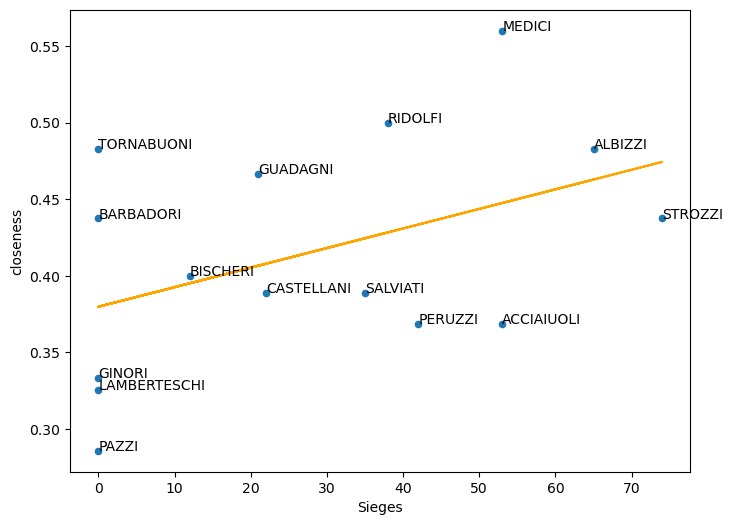

Coeff. de Pearsons: 0.9254
Coeff. de Spearman: 0.402788270813957


In [198]:
centrality = 'closeness'
#centrality = 'eigenvector'
#centrality = 'betweenness'

export.plot(x = 'Sieges', y=centrality, kind='scatter',figsize=(8,6))
for i,row in list(export[['Sieges', centrality]].iterrows()):
    plt.annotate(i,(row['Sieges'], row[centrality]))

x = export['Sieges']
y = export[centrality]
# m = slope, b=intercept
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='orange')    
plt.show()

print('Coeff. de Pearsons: {}'.format(np.corrcoef(degree, eigenvector)[1][0].round(4)))
corr_spear = export[['Sieges',centrality]].corr(method="spearman")

print('Coeff. de Spearman: {}'.format(corr_spear.iloc[0,1]))


In [199]:
linregress(x, y)

LinregressResult(slope=0.0012780715318496374, intercept=0.3797355413177179, rvalue=0.4410564900727464, pvalue=0.09983189922576559, stderr=0.0007212963423266927, intercept_stderr=0.026873169564360325)

In [200]:
### https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
res = stats.spearmanr(x,y)
res.statistic, res.pvalue

(0.402788270813957, 0.13660106355265897)

In [201]:
node_colors = []
for n in G.nodes.data():
    if n[1]['Parti'] == 'GIR':
        node_colors.append(['GIR', 'DarkGreen'])
    if n[1]['Parti'] == 'MED':
        node_colors.append(['MED','Coral'])
    if n[1]['Parti'] == 'OLI':
        node_colors.append(['OLI','DeepSkyBlue'])
        
print(len(node_colors))
node_colors[:3]

15


[['MED', 'Coral'], ['MED', 'Coral'], ['OLI', 'DeepSkyBlue']]

### Comparer sièges et pouvoir

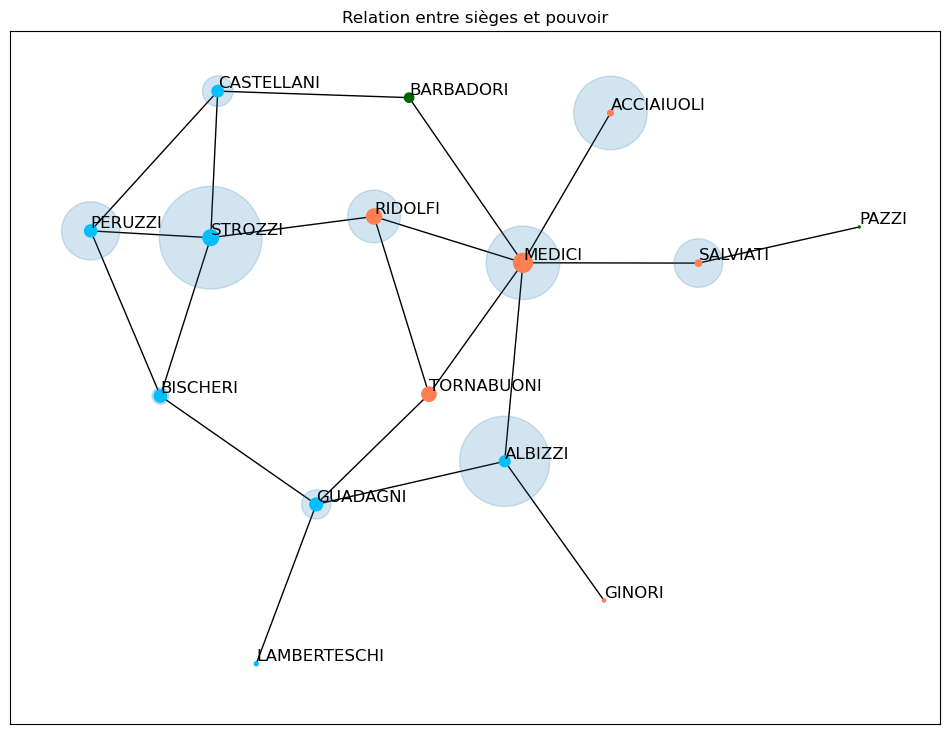

In [202]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (12,9))

#centrality = 'closeness'
centrality = 'eigenvector'
#centrality = 'betweenness'


### Adapter la taille des attribut à l'affichage
node_sizes = [i[1][centrality] ** 2 * 1000 for i in list(G.nodes.data())]


#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G, pos, node_size= sieges**2, alpha=0.2)
nx.draw_networkx(G, pos, node_size=node_sizes, node_color=[c[1] for c in node_colors],\
                horizontalalignment='left', verticalalignment='bottom')
plt.title('Relation entre sièges et pouvoir')
plt.show()
## Une nouvelle information : les familles les plus riches se trouvent au centre du réseau
#  Ce n'est pas nécessairement le cas

### Relations entre revenus et pouvoir/influence

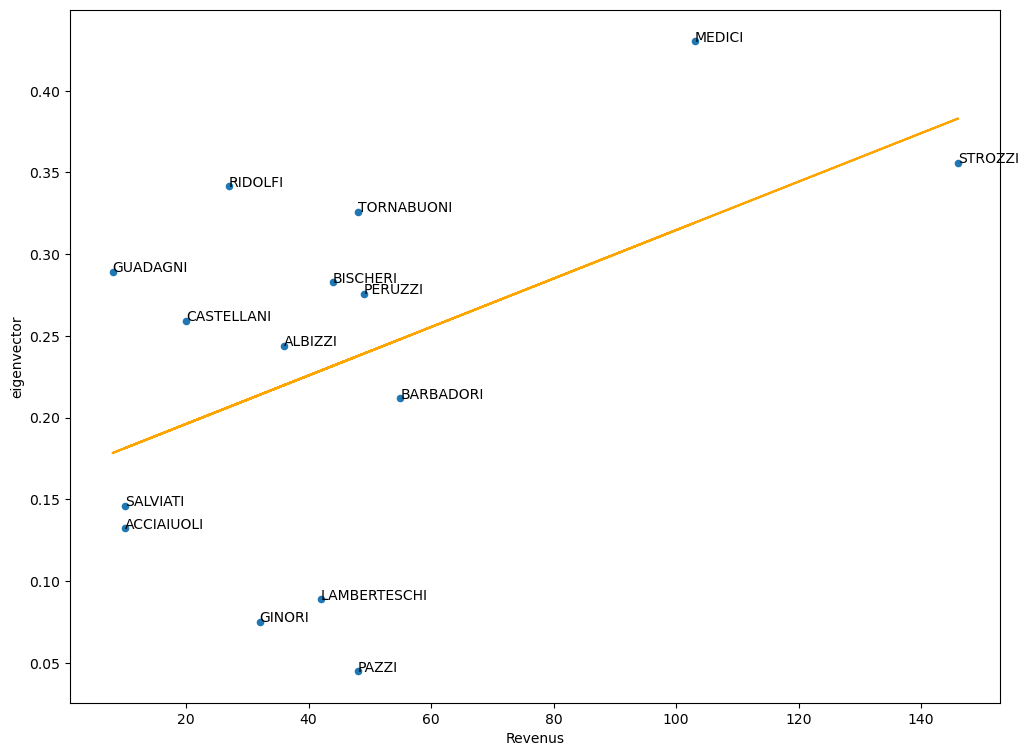

In [203]:
export.plot(x = 'Revenus', y = 'eigenvector',kind='scatter', figsize=(12,9))
for i,row in list(export[['Revenus','eigenvector']].iterrows()):
    plt.annotate(i,(row['Revenus'], row['eigenvector']))

x = export['Revenus']
y = export['eigenvector']
# m = slope, b=intercept
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='orange')    
plt.show()

In [204]:
print('Pearsons (revenus-eigenvector): {}'.format(np.corrcoef(revenus, eigenvector)[1][0].round(4)))
corr_spear = export[['Revenus','eigenvector']].corr(method="spearman")
# corr_spear
print('Spearman (revenus-eigenvector): {}'.format(corr_spear.iloc[0,1]))

Pearsons (revenus-eigenvector): 0.4755
Spearman (revenus-eigenvector): 0.31484844654346733


In [205]:
linregress(x, y)

LinregressResult(slope=0.001482964819433415, intercept=0.16647799398540997, rvalue=0.4755441918560369, pvalue=0.07319523673855427, stderr=0.0007608496595878047, intercept_stderr=0.04365093807340314)

In [206]:
### https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
res = stats.spearmanr(x,y)
res.statistic, res.pvalue

(0.3148484465434674, 0.25304468800566526)

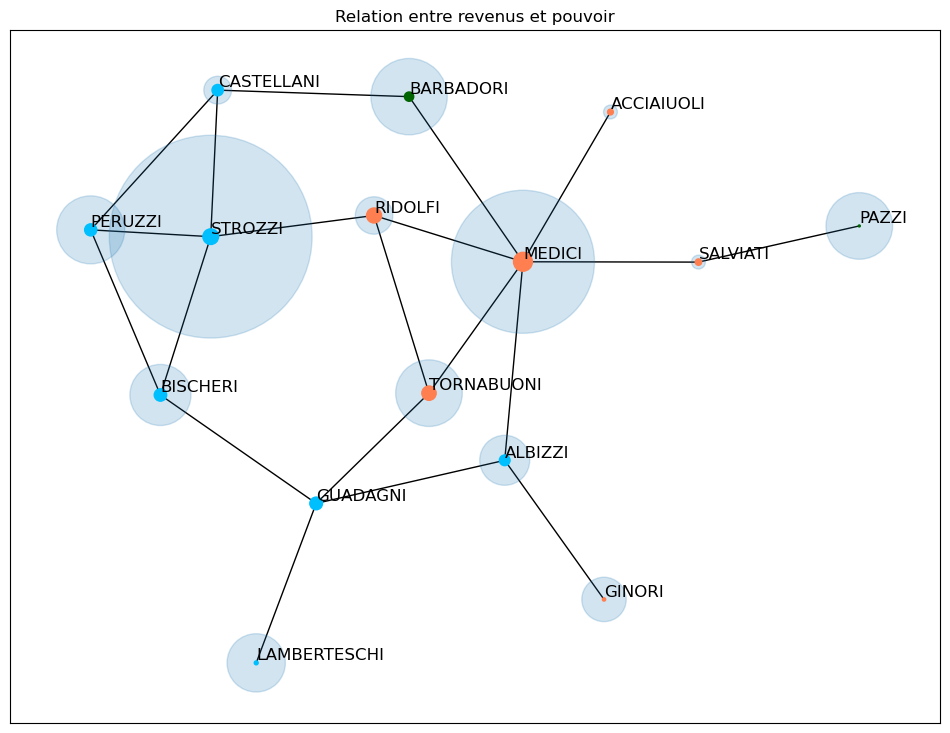

In [209]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (12,9))

#centrality = 'closeness'
centrality = 'eigenvector'
#centrality = 'betweenness'


### Adapter la taille des attribut à l'affichage
node_sizes = [i[1][centrality] ** 2 * 1000 for i in list(G.nodes.data())]


#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G, pos, node_size= revenus**2, alpha=0.2)
nx.draw_networkx(G, pos, node_size=node_sizes, node_color=[c[1] for c in node_colors],\
                horizontalalignment='left', verticalalignment='bottom')
plt.title('Relation entre revenus et pouvoir')
plt.show()
## Une nouvelle information : les familles les plus riches se trouvent au centre du réseau
#  Ce n'est pas nécessairement le cas

### Relations entre revenus et influence

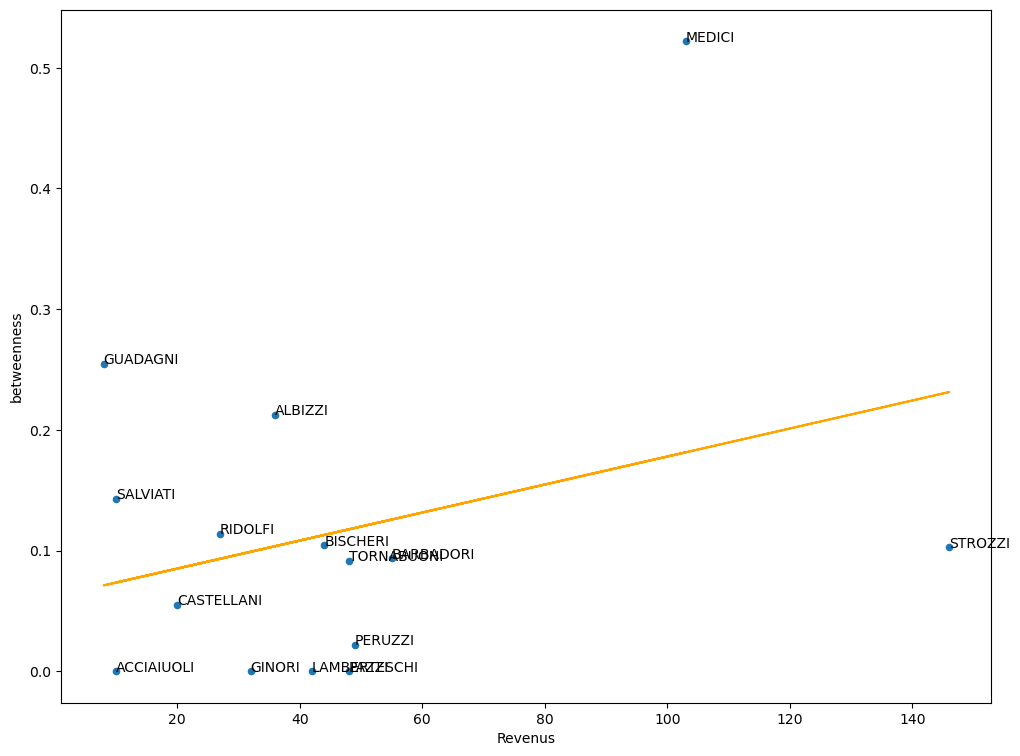

Coeff. de Pearsons: 0.9254
Coeff. de Spearman: -0.021661214442955292


In [212]:
#centrality = 'closeness'
#centrality = 'eigenvector'
centrality = 'betweenness'
explicative = 'Revenus'

export.plot(x = explicative, y=centrality, kind='scatter',figsize=(12,9))
for i,row in list(export[[explicative, centrality]].iterrows()):
    plt.annotate(i,(row[explicative], row[centrality]))

x = export[explicative]
y = export[centrality]
# m = slope, b=intercept
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='orange')    
plt.show()

print('Coeff. de Pearsons: {}'.format(np.corrcoef(degree, eigenvector)[1][0].round(4)))
corr_spear = export[[explicative,centrality]].corr(method="spearman")

print('Coeff. de Spearman: {}'.format(corr_spear.iloc[0,1]))


In [178]:
linregress(x, y)

LinregressResult(slope=0.001160611005535817, intercept=0.061826096835495364, rvalue=0.31039163302766143, pvalue=0.2601886623357711, stderr=0.0009858408711622387, intercept_stderr=0.05655897755234066)

In [213]:
### https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
res = stats.spearmanr(x,y)
res.statistic, res.pvalue

(-0.0216612144429553, 0.9389230430644325)

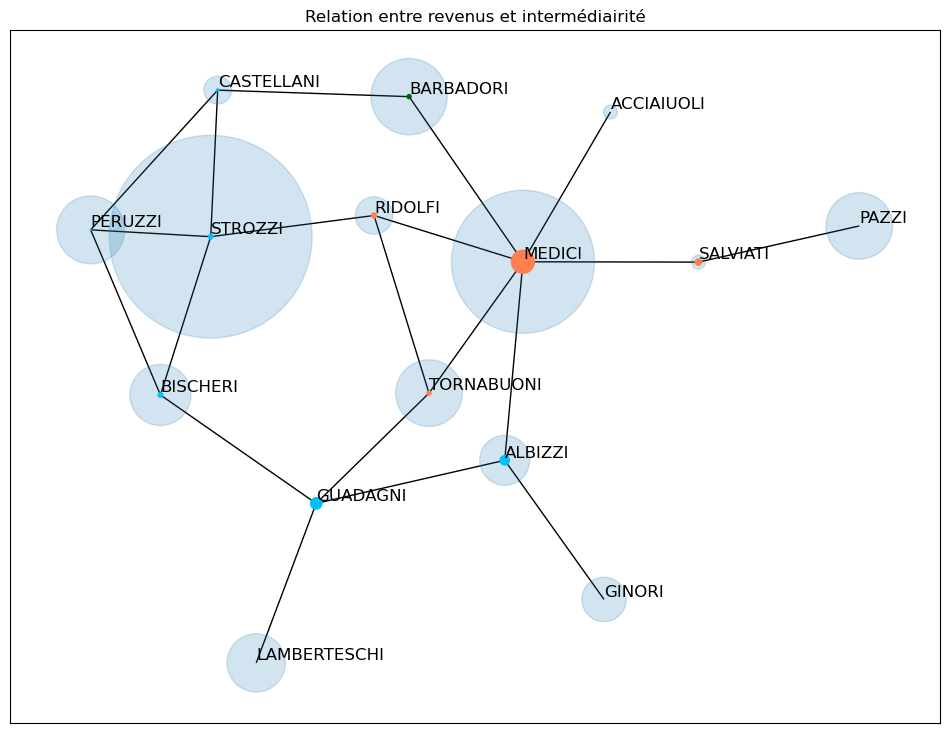

In [214]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (12,9))

#centrality = 'closeness'
#centrality = 'eigenvector'
centrality = 'betweenness'


### Adapter la taille des attribut à l'affichage
node_sizes = [i[1][centrality] ** 2 * 1000 for i in list(G.nodes.data())]


#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G, pos, node_size= revenus**2, alpha=0.2)
nx.draw_networkx(G, pos, node_size=node_sizes, node_color=[c[1] for c in node_colors],\
                horizontalalignment='left', verticalalignment='bottom')
plt.title('Relation entre revenus et intermédiairité')
plt.show()
## Une nouvelle information : les familles les plus riches se trouvent au centre du réseau
#  Ce n'est pas nécessairement le cas

### Intermédiarité, eigenvector, revenus et sièges

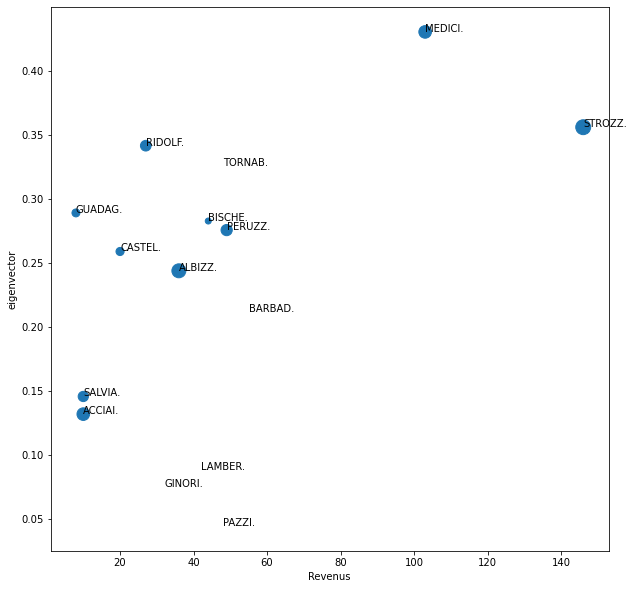

In [100]:
export.plot(x = 'Revenus', y = 'eigenvector',kind='scatter',figsize=(10,10), s=[s*3 for s in export.Sieges])
for i,row in list(export[['Revenus','eigenvector']].iterrows()):
    plt.annotate(i[0:6]+'.',(row['Revenus'], row['eigenvector']))

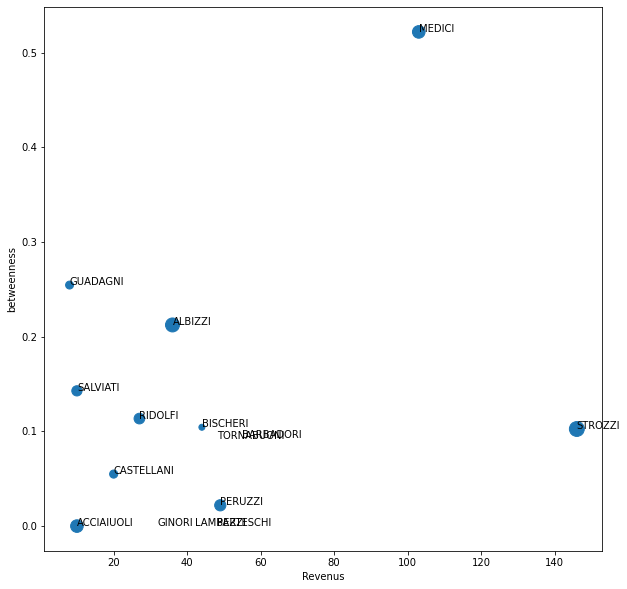

In [102]:
export.plot(x = 'Revenus', y = 'betweenness',kind='scatter',figsize=(10,10), s=[s*3 for s in export.Sieges])
for i,row in list(export[['Revenus','betweenness']].iterrows()):
    plt.annotate(i,(row['Revenus'], row['betweenness']))

In [118]:
### Adapter la taille des attribut à l'affichage
node_sizes = [i[1]['betweenness'] * 5000 + 10 for i in list(G.nodes.data())]

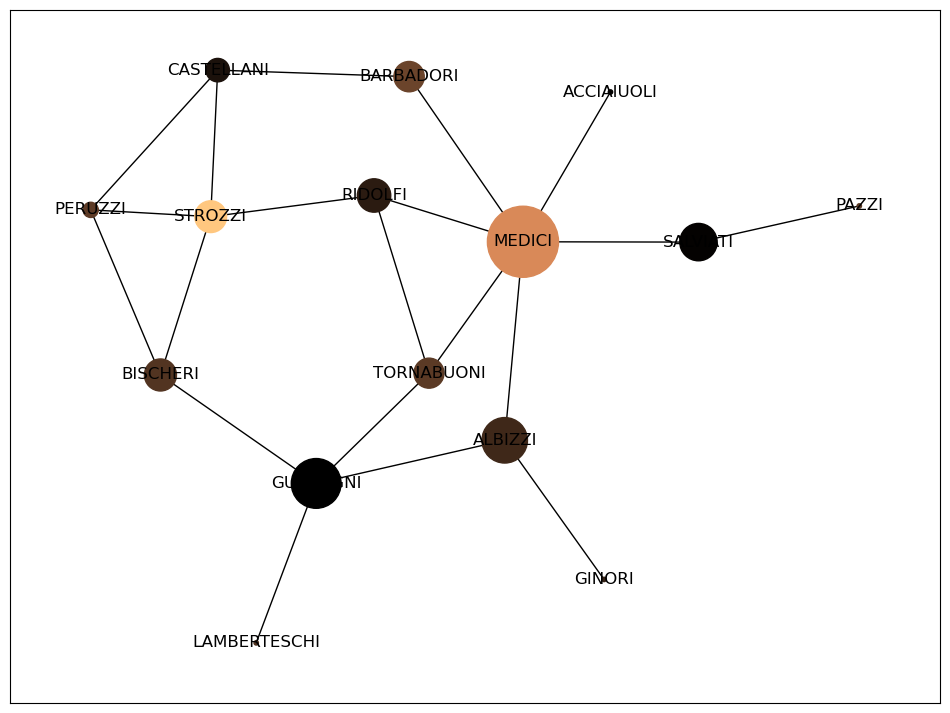

In [145]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (12,9))

#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)

node_color = [i[1]['Revenus'] for i in list(G.nodes.data())]
nx.draw_networkx(G, pos, node_size=node_sizes, node_color=node_color, cmap='copper')

## Une nouvelle information : les familles les plus riches se trouvent au centre du réseau
#  Ce n'est pas nécessairement le cas

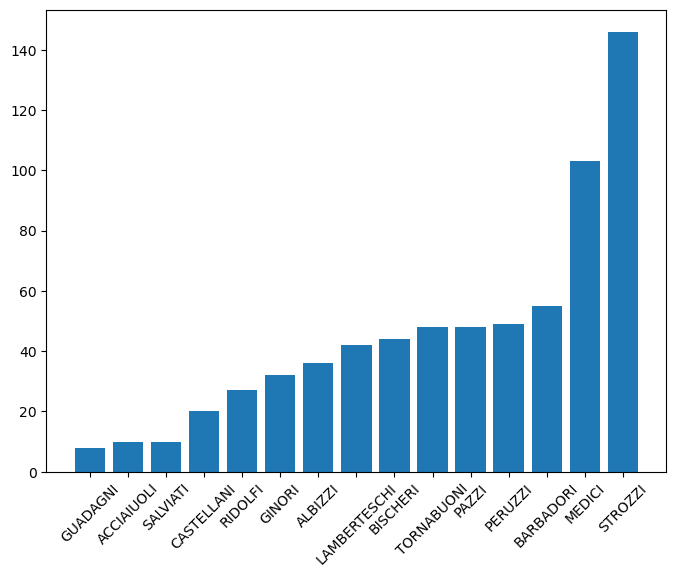

In [143]:
_ = plt.figure(figsize=(8,6))
s = export.sort_values(by='Revenus')
plt.bar(s.index, s['Revenus'])
plt.xticks(rotation=45)
plt.show()

### Graphe : partis et intermédiarité

Le parti est représenté par la couleur des noeuds, la centralité d'intermédiarité par le diamètre du noeud.

La valuer de l'intermédiarité est artificiellement augmentée (par une multiplication et l'ajout d'une valeur minimale) afin de produire un graphe lisible.

In [189]:
node_sizes = [i[1]['betweenness'] **2 * 1000 for i in list(G.nodes.data())]
print(len(node_sizes))
node_sizes[:4]

15


[0.0, 272.4610554280884, 45.136792389539664, 0.0]

In [190]:
## effectifs par parti
l_partis = [n[1]['Parti'] for n in G.nodes.data()]
l_partis.sort()
list((k,len(list(v))) for k,v in itertools.groupby(l_partis))

[('GIR', 2), ('MED', 6), ('OLI', 7)]

In [191]:
node_colors = []
for n in G.nodes.data():
    if n[1]['Parti'] == 'GIR':
        node_colors.append(['GIR', 'DarkCyan'])
    if n[1]['Parti'] == 'MED':
        node_colors.append(['MED','Coral'])
    if n[1]['Parti'] == 'OLI':
        node_colors.append(['OLI','DeepSkyBlue'])
        
print(len(node_colors))
node_colors[:3]

15


[['MED', 'Coral'], ['MED', 'Coral'], ['OLI', 'DeepSkyBlue']]

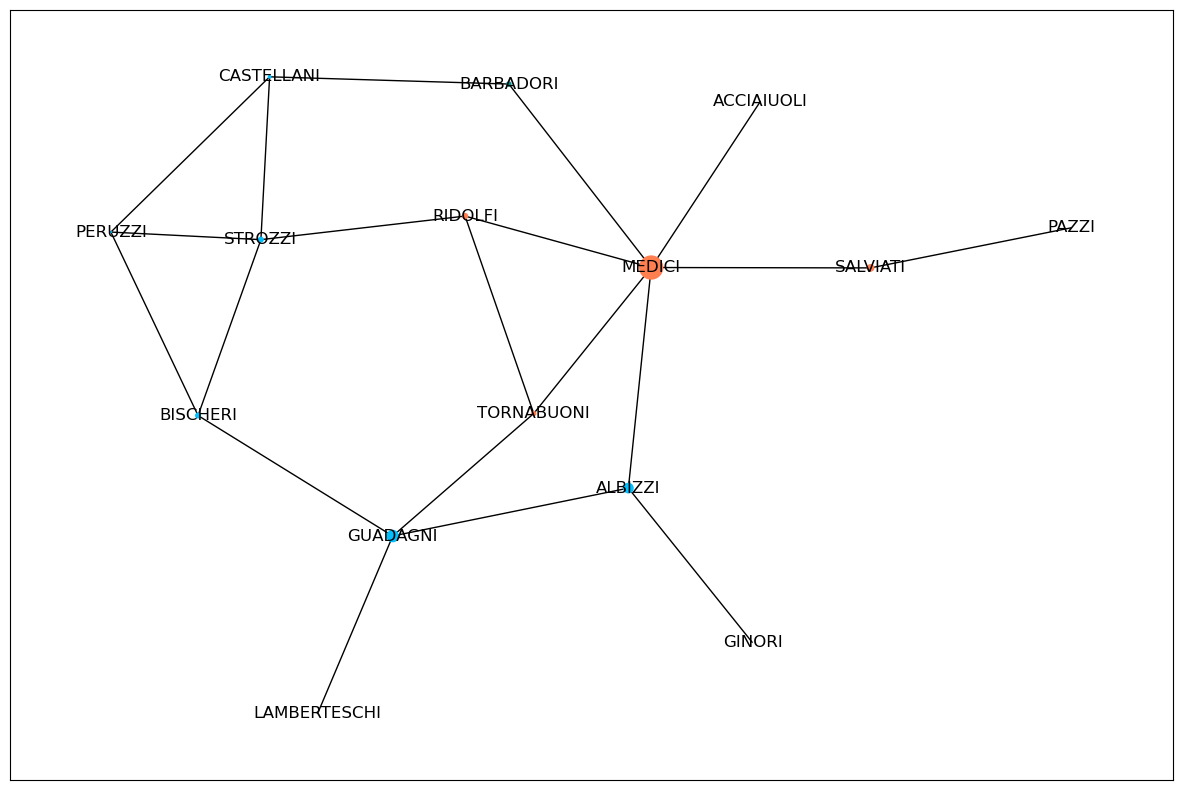

In [192]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,10))

#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)


nx.draw_networkx(G, pos, node_color=[c[1] for c in node_colors], node_size=node_sizes)

### Relations entre nombre de sièges et influence

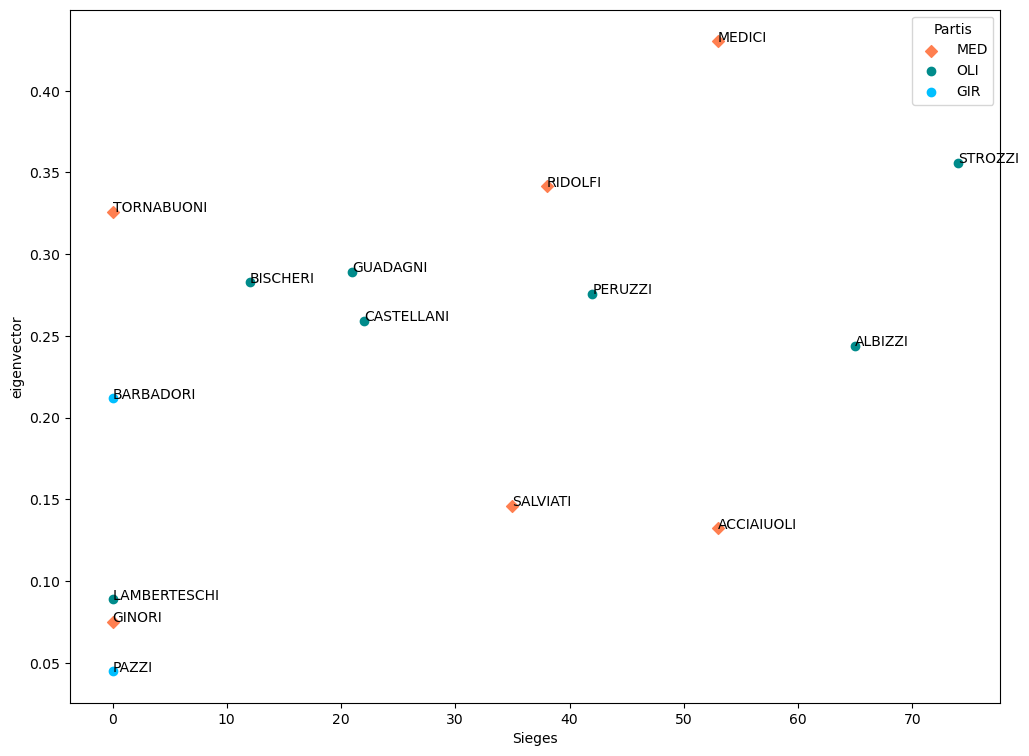

In [156]:
### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
# Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point


plt.figure(figsize=(12,9))

plt.scatter(export['Sieges'][(export.Parti == 'MED')], #  | (export.Parti == 'MED')],
            export['eigenvector'][(export.Parti == 'MED')], #  | (export.Parti == 'MED')],
           marker='D',
           color='Coral',
           label='MED')
plt.scatter(export['Sieges'][export.Parti == 'OLI'],
            export['eigenvector'][export.Parti == 'OLI'],
           marker='o',
           color='DarkCyan',
           label='OLI')
plt.scatter(export['Sieges'][export.Parti == 'GIR'],
            export['eigenvector'][export.Parti == 'GIR'],
           marker='o',
           color='DeepSkyBlue',
           label='GIR')
plt.xlabel('Sieges')
plt.ylabel('eigenvector')

for i,row in list(export[['Sieges','eigenvector']].iterrows()):
    plt.annotate(i,(row['Sieges'], row['eigenvector']))
plt.legend(title='Partis')
plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [144]:
### Calculer les coefficients de correlations dans Pandas
# Doc. : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
print('Pearsons (sieges-eigenvector): {}'.format(np.corrcoef(sieges, eigenvector)[1][0].round(4)))
corr_spear = export[['Sieges','eigenvector']].corr(method="spearman")
# corr_spear
print('Spearman (sieges-eigenvector): {}'.format(corr_spear.iloc[0,1]))

Pearsons (sieges-eigenvector): 0.4834
Spearman (sieges-eigenvector): 0.4823446633248956


### Relations entre revenu et influence

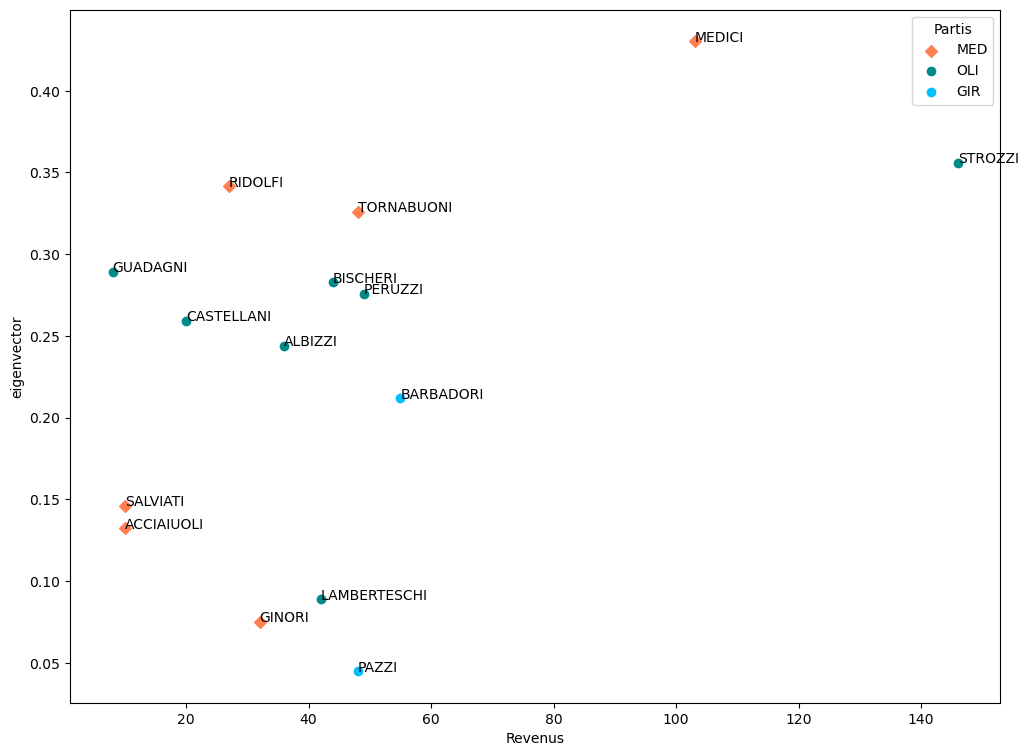

In [157]:
### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
# Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point


plt.figure(figsize=(12,9))

plt.scatter(export['Revenus'][(export.Parti == 'MED')], #  | (export.Parti == 'MED')],
            export['eigenvector'][(export.Parti == 'MED')], #  | (export.Parti == 'MED')],
           marker='D',
           color='Coral',
           label='MED')
plt.scatter(export['Revenus'][export.Parti == 'OLI'],
            export['eigenvector'][export.Parti == 'OLI'],
           marker='o',
           color='DarkCyan',
           label='OLI')
plt.scatter(export['Revenus'][export.Parti == 'GIR'],
            export['eigenvector'][export.Parti == 'GIR'],
           marker='o',
           color='DeepSkyBlue',
           label='GIR')
plt.xlabel('Revenus')
plt.ylabel('eigenvector')

for i,row in list(export[['Revenus','eigenvector']].iterrows()):
    plt.annotate(i,(row['Revenus'], row['eigenvector']))
plt.legend(title='Partis')
plt.savefig('plots/revenus_eigenvector_20210526.jpg')
plt.show()

In [121]:
print('Pearsons (revenus-eigenvector): {}'.format(np.corrcoef(revenus, eigenvector)[1][0].round(4)))
corr_spear = export[['Revenus','eigenvector']].corr(method="spearman")
# corr_spear
print('Spearman (revenus-eigenvector): {}'.format(corr_spear.iloc[0,1]))

Pearsons (revenus-eigenvector): 0.4755
Spearman (revenus-eigenvector): 0.31484844654346733


### Relations entre revenu et sièges

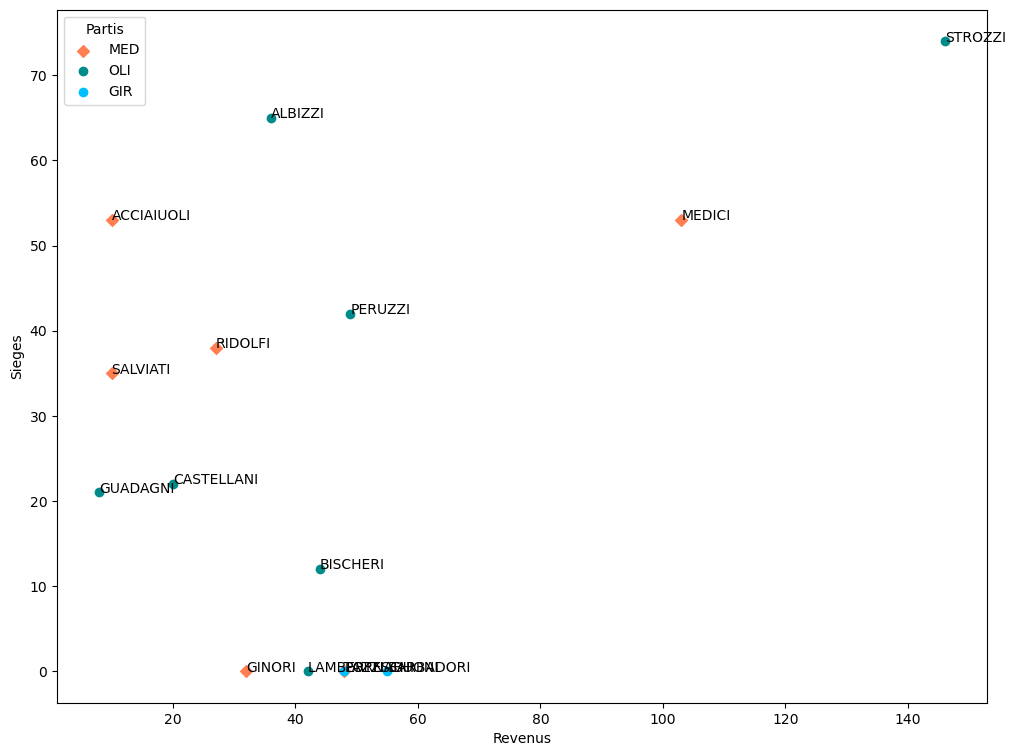

In [158]:
### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
# Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point


plt.figure(figsize=(12,9))

plt.scatter(export['Revenus'][(export.Parti == 'MED')], #  | (export.Parti == 'MED')],
            export['Sieges'][(export.Parti == 'MED')], #  | (export.Parti == 'MED')],
           marker='D',
           color='Coral',
           label='MED')
plt.scatter(export['Revenus'][export.Parti == 'OLI'],
            export['Sieges'][export.Parti == 'OLI'],
           marker='o',
           color='DarkCyan',
           label='OLI')
plt.scatter(export['Revenus'][export.Parti == 'GIR'],
            export['Sieges'][export.Parti == 'GIR'],
           marker='o',
           color='DeepSkyBlue',
           label='GIR')
plt.xlabel('Revenus')
plt.ylabel('Sieges')

for i,row in list(export[['Revenus','Sieges']].iterrows()):
    plt.annotate(i,(row['Revenus'], row['Sieges']))
plt.legend(title='Partis')
plt.savefig('plots/revenus_eigenvector_20210526.jpg')
plt.show()

# Cohésion et cliques

In [122]:
nx.is_connected(G), nx.density(G)

(True, 0.19047619047619047)

In [123]:
### Returns all maximal cliques in an undirected graph.
# Clique : sous-ensemble de noeuds où toutes les paires de noeuds existants sont connectés. 
# https://networkx.org/documentation/stable/reference/algorithms/clique.html?highlight=cliques

[list(nx.find_cliques(G))]
[c for c in list(nx.find_cliques(G)) if len(c) > 2]

[['BISCHERI', 'STROZZI', 'PERUZZI'],
 ['CASTELLANI', 'PERUZZI', 'STROZZI'],
 ['MEDICI', 'TORNABUONI', 'RIDOLFI']]

In [124]:
#  https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html
S = [[len(c), G.subgraph(c).copy()] for c in nx.find_cliques(G) if len(c) > 2]
# type(S)

In [125]:
a = [[s[0], s[1]] for s in S]
a

[[3, <networkx.classes.graph.Graph at 0x7f1536614af0>],
 [3, <networkx.classes.graph.Graph at 0x7f15366145b0>],
 [3, <networkx.classes.graph.Graph at 0x7f15369fad60>]]

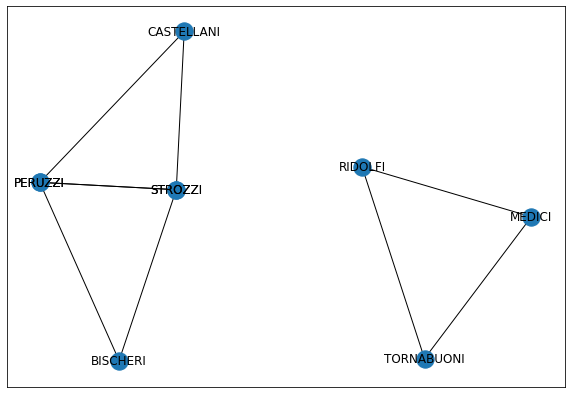

In [126]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (10,7))

#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)

for s in S:
    nx.draw_networkx(s[1], pos)


In [127]:
### https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.kcomponents.k_components.html#networkx.algorithms.connectivity.kcomponents.k_components
# "A k-component is a maximal subgraph of a graph G that has, at least, node connectivity k: we need to remove at least k nodes to break it into more components."

nx.k_components(G)

{2: [{'ALBIZZI',
   'BARBADORI',
   'BISCHERI',
   'CASTELLANI',
   'GUADAGNI',
   'MEDICI',
   'PERUZZI',
   'RIDOLFI',
   'STROZZI',
   'TORNABUONI'}],
 1: [{'ACCIAIUOLI',
   'ALBIZZI',
   'BARBADORI',
   'BISCHERI',
   'CASTELLANI',
   'GINORI',
   'GUADAGNI',
   'LAMBERTESCHI',
   'MEDICI',
   'PAZZI',
   'PERUZZI',
   'RIDOLFI',
   'SALVIATI',
   'STROZZI',
   'TORNABUONI'}]}

In [133]:
###https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.kcomponents.k_components.html?highlight=k_components#networkx.algorithms.approximation.kcomponents.k_components

from networkx.algorithms import approximation as apxa
apxa.k_components(G, min_density = 0.9)

defaultdict(list,
            {1: [{'ACCIAIUOLI',
               'ALBIZZI',
               'BARBADORI',
               'BISCHERI',
               'CASTELLANI',
               'GINORI',
               'GUADAGNI',
               'LAMBERTESCHI',
               'MEDICI',
               'PAZZI',
               'PERUZZI',
               'RIDOLFI',
               'SALVIATI',
               'STROZZI',
               'TORNABUONI'}],
             2: [{'ALBIZZI',
               'BARBADORI',
               'BISCHERI',
               'CASTELLANI',
               'GUADAGNI',
               'MEDICI',
               'PERUZZI',
               'RIDOLFI',
               'STROZZI',
               'TORNABUONI'}]})

In [134]:
kG = nx.k_core(G, k=2)
nx.info(kG)

'Graph with 10 nodes and 15 edges'

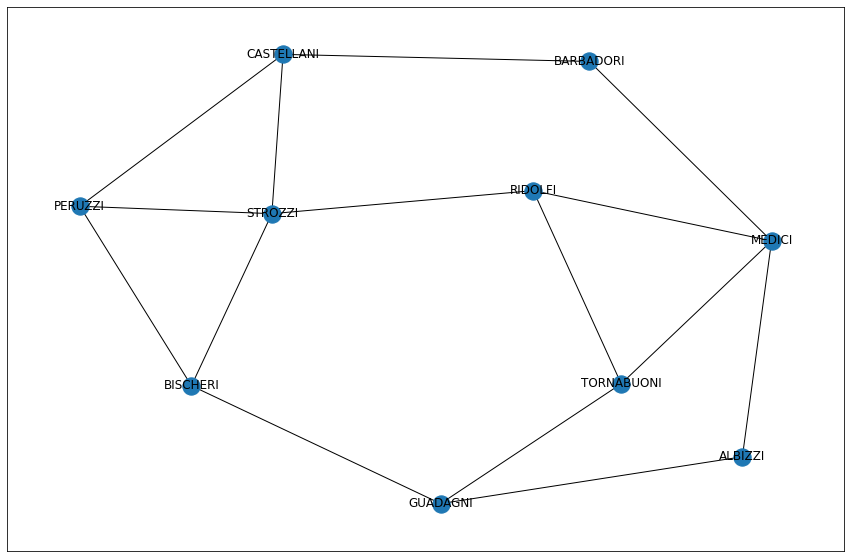

In [139]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,10))

#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx(kG, pos)


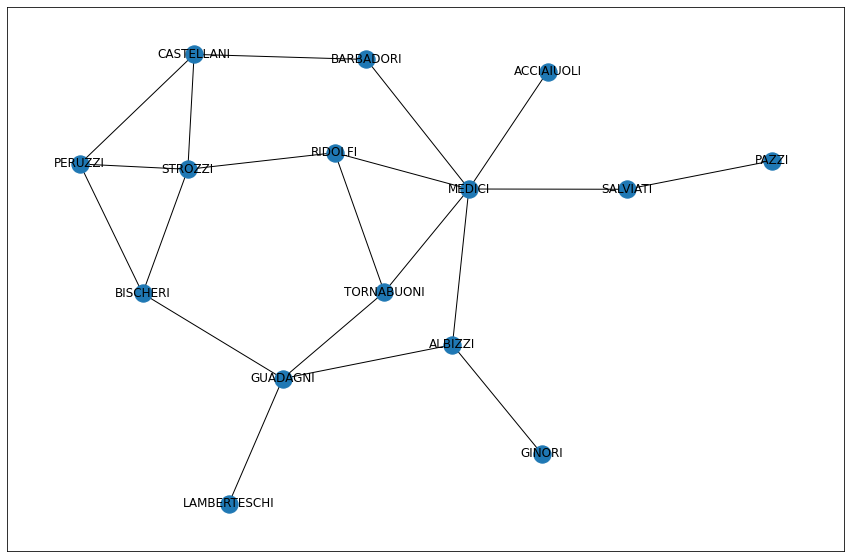

In [136]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,10))

#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx(G, pos)


In [141]:
nx.has_bridges(G), list(nx.bridges(G))

(True,
 [('ACCIAIUOLI', 'MEDICI'),
  ('MEDICI', 'SALVIATI'),
  ('ALBIZZI', 'GINORI'),
  ('GUADAGNI', 'LAMBERTESCHI'),
  ('SALVIATI', 'PAZZI')])

## Nouveau _graphe ad hoc_

In [144]:
PKB = nx.read_pajek('../manuels/cellier_cocaud_chap_11-15/florence_bridges.net')
print(nx.info(PKB))

MultiGraph with 35 nodes and 42 edges


In [145]:
### Y a-t-il des loops ? Un sommet en relation avec lui même ?
# https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.nodes_with_selfloops.html
list(nx.nodes_with_selfloops(PKB))

[]

In [146]:
### Nettoyer le graphe original (format Pajek .net)

GB = nx.Graph(PKB)
e = GB.nodes()
pop = [GB.nodes[n].pop('id',None) for n in e]
print(GB.nodes.data())

[('ACCIAIUOLI', {}), ('ALBIZZI', {}), ('BARBADORI', {}), ('BISCHERI', {}), ('CASTELLANI', {}), ('GINORI', {}), ('GUADAGNI', {}), ('LAMBERTESCHI', {}), ('MEDICI', {}), ('PAZZI', {}), ('PERUZZI', {}), ('RIDOLFI', {}), ('SALVIATI', {}), ('STROZZI', {}), ('TORNABUONI', {}), ('D1', {}), ('D2', {}), ('D3', {}), ('D4', {}), ('D5', {}), ('ACCIAIUOLI_2', {}), ('ALBIZZI_2', {}), ('BARBADORI_2', {}), ('BISCHERI_2', {}), ('CASTELLANI_2', {}), ('GINORI_2', {}), ('GUADAGNI_2', {}), ('LAMBERTESCHI_2', {}), ('MEDICI_2', {}), ('PAZZI_2', {}), ('PERUZZI_2', {}), ('RIDOLFI_2', {}), ('SALVIATI_2', {}), ('STROZZI_2', {}), ('TORNABUONI_2', {})]


In [147]:
### Principales caractéristiques de ce graphe

GB.is_multigraph(), GB.is_directed(), GB.number_of_nodes(), GB.number_of_edges(), nx.is_connected(GB), nx.density(GB)

(False, False, 35, 42, False, 0.07058823529411765)

In [148]:
nx.number_connected_components(GB)

6

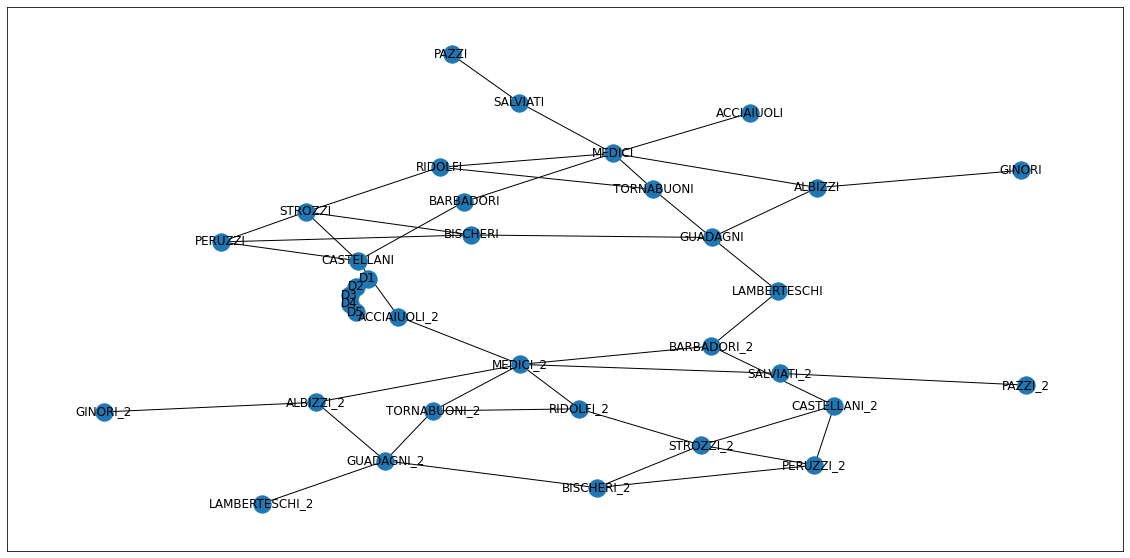

In [149]:
### Un premier affichage (ne marche que avec peu de sommets)

# l'algorithme cherche la meilleure position des somments
# si on exécute plurieurs fois l'apparence peut changer
pos = nx.kamada_kawai_layout(GB)
plt.figure(figsize = (20,10))
nx.draw_networkx(GB, pos)

In [150]:
## Centralité et dispersion du degré
df_degree = pd.DataFrame(list(nx.degree(GB)), columns = ['famille', 'degree'])
df_degree.head()
df_degree.set_index(['famille'],inplace=True)
df_degree.head()

,degree
famille,
ACCIAIUOLI,1
ALBIZZI,3
BARBADORI,2
BISCHERI,3
CASTELLANI,4


In [151]:
df_degree['degree'].describe()

count                 35.0
mean                   2.4
std      1.575548457260668
min                    0.0
25%                    1.0
50%                    3.0
75%                    3.0
max                    6.0
Name: degree, dtype: float64

In [152]:
list(df_degree[df_degree['degree']== 0].index)

['D1', 'D2', 'D3', 'D4', 'D5']

### Graphe avec sommets de degré plus grand que 0 (dans l'original)

In [182]:
#  https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html
SG0 = GB.subgraph(list(df_degree[df_degree['degree'] > 0].index)).copy()
nx.number_connected_components(SG0)

1

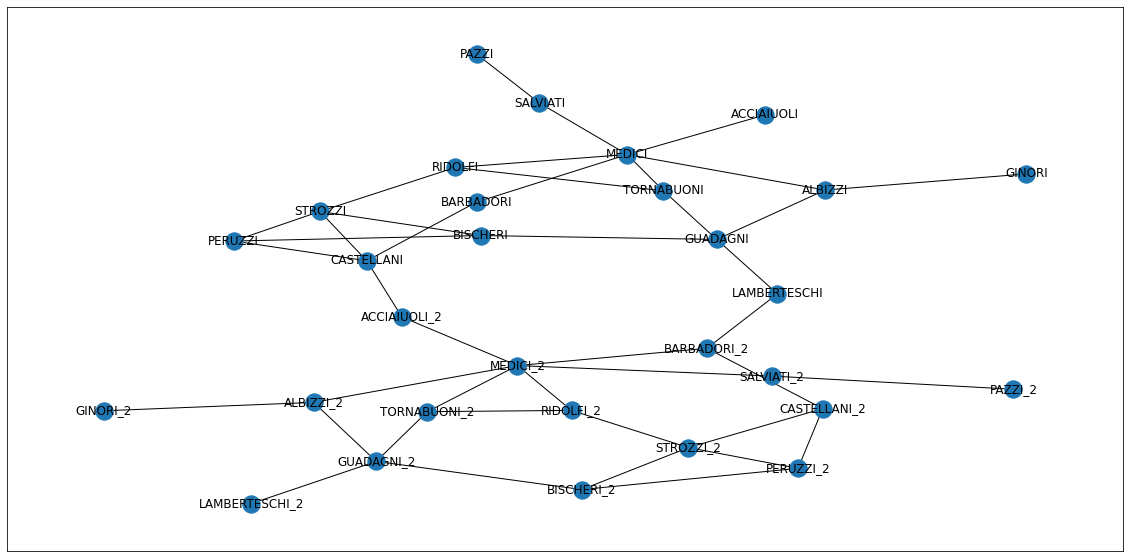

In [183]:
### Un premier affichage (ne marche que avec peu de sommets)

# l'algorithme cherche la meilleure position des somments
# si on exécute plurieurs fois l'apparence peut changer
pos = nx.kamada_kawai_layout(SG0)
plt.figure(figsize = (20,10))
nx.draw_networkx(SG0, pos)

### Graphe avec sommets de degré strictement plus grand que 2 (dans l'original)

In [223]:
#  https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html
SG2 = SG0.subgraph(list(df_degree[df_degree['degree'] > 2].index)).copy()
nx.number_connected_components(SG2)

2

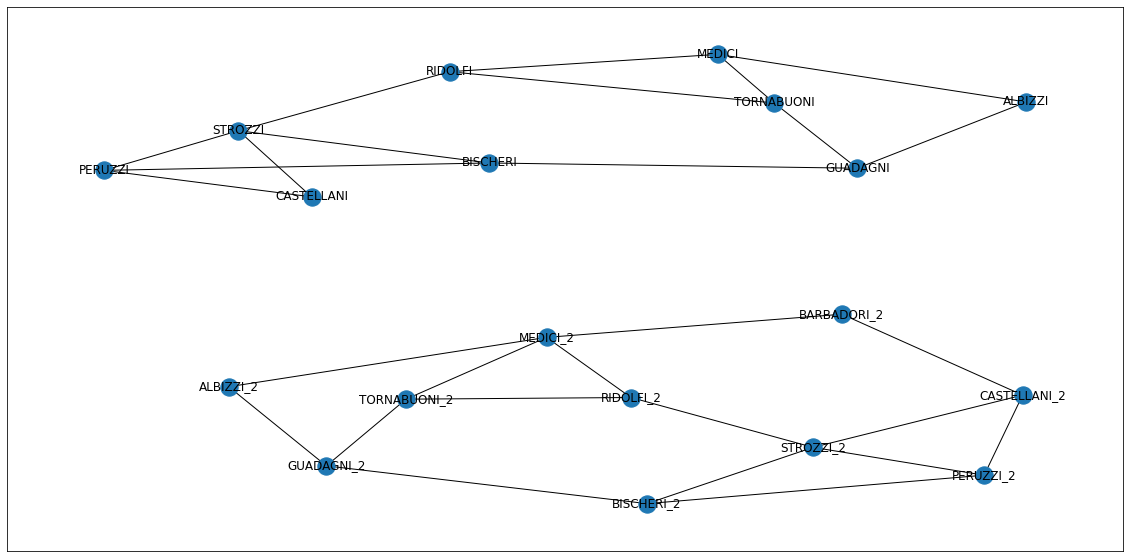

In [237]:
### Un premier affichage (ne marche que avec peu de sommets)

plt.figure(figsize = (20,10))
pos = nx.kamada_kawai_layout(SG0)
nx.draw_networkx(SG2, pos)

# Bridges

* https://en.wikipedia.org/wiki/Bridge_%28graph_theory%29#Bridge-Finding_with_Chain_Decompositions

In [262]:
### https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.bridges.bridges.html#networkx.algorithms.bridges.bridges
nx.has_bridges(SG0), list(nx.bridges(SG0))

(True,
 [('ACCIAIUOLI', 'MEDICI'),
  ('ALBIZZI', 'GINORI'),
  ('MEDICI', 'SALVIATI'),
  ('PAZZI', 'SALVIATI'),
  ('ALBIZZI_2', 'GINORI_2'),
  ('GUADAGNI_2', 'LAMBERTESCHI_2'),
  ('MEDICI_2', 'SALVIATI_2'),
  ('PAZZI_2', 'SALVIATI_2')])

In [267]:
### étonnamment ACCIAIUOLI_2 et LAMBERTESCHI ne figurent pas dans cette liste

l = []
for e in list(nx.bridges(SG0)):
    l += e
sorted(set(l))

['ACCIAIUOLI',
 'ALBIZZI',
 'ALBIZZI_2',
 'GINORI',
 'GINORI_2',
 'GUADAGNI_2',
 'LAMBERTESCHI_2',
 'MEDICI',
 'MEDICI_2',
 'PAZZI',
 'PAZZI_2',
 'SALVIATI',
 'SALVIATI_2']

In [268]:
### Fonction qui crée la différence par sustraction entre deux listes
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

In [269]:
### Différence des graphes complet et de degré supérieur à 2
D = SG0.edges() - SG2.edges()
Diff(list(D),list(nx.bridges(SG0)))

[('CASTELLANI', 'ACCIAIUOLI_2'),
 ('BARBADORI', 'CASTELLANI'),
 ('ACCIAIUOLI_2', 'MEDICI_2'),
 ('GUADAGNI', 'LAMBERTESCHI'),
 ('BARBADORI', 'MEDICI'),
 ('LAMBERTESCHI', 'BARBADORI_2')]

In [271]:
### Créer un graphe à partir des arêtes composant la différence
GD = nx.Graph()
DL = Diff(list(D),list(nx.bridges(SG0)))
GD.add_edges_from(DL)
print(DL)

[('CASTELLANI', 'ACCIAIUOLI_2'), ('BARBADORI', 'CASTELLANI'), ('ACCIAIUOLI_2', 'MEDICI_2'), ('GUADAGNI', 'LAMBERTESCHI'), ('BARBADORI', 'MEDICI'), ('LAMBERTESCHI', 'BARBADORI_2')]


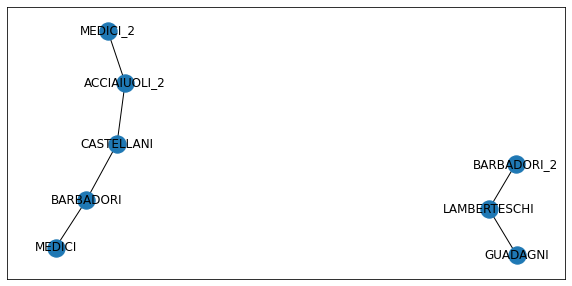

In [275]:
### Afficher la différence
plt.figure(figsize = (10,5))
pos = nx.kamada_kawai_layout(SG0)
nx.draw_networkx(GD)

In [276]:
### Créer la liste des noeuds concernés par la différence des graphes
DLAdd = []
for d in DL:
    DLAdd += d
DL1 = list(set(DLAdd))
DL1

['MEDICI_2',
 'GUADAGNI',
 'BARBADORI_2',
 'CASTELLANI',
 'BARBADORI',
 'ACCIAIUOLI_2',
 'LAMBERTESCHI',
 'MEDICI']

In [278]:
### Ajouter aux noeux différence une couleur spécifique
node_colors = []
for n in SG0.nodes:
    if n in DL1:
        node_colors.append('Coral')
    else:    
        node_colors.append('DeepSkyBlue')
        
print(len(node_colors))
node_colors[:3]

30


['DeepSkyBlue', 'DeepSkyBlue', 'Coral']

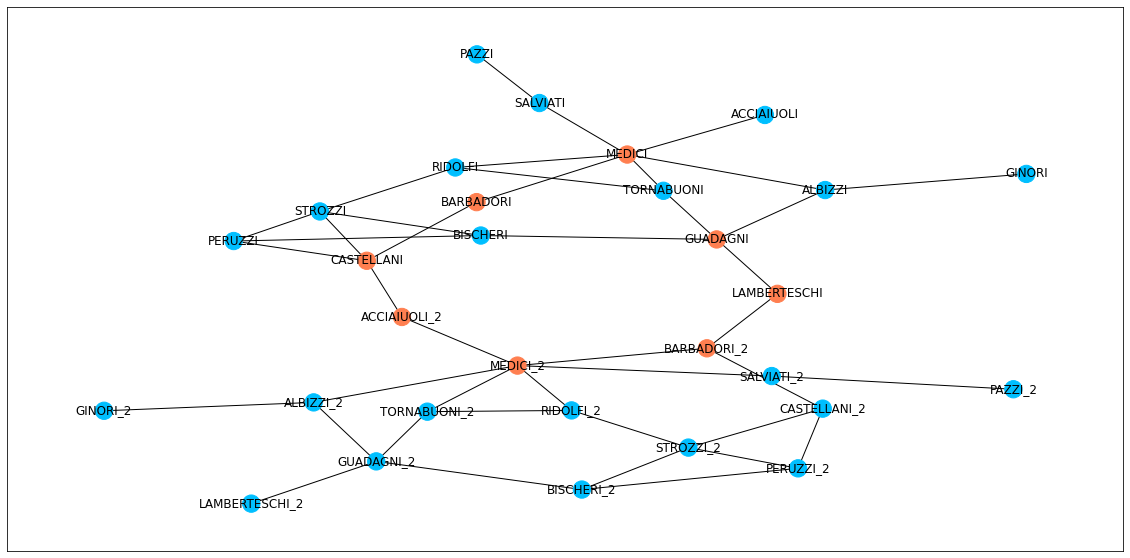

In [279]:
pos = nx.kamada_kawai_layout(SG0)
plt.figure(figsize = (20,10))
nx.draw_networkx(SG0, pos,node_color=node_colors)

## Ajouter les paramètres de centralité

### Centralité de degré

In [157]:
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(SG0)])
nx.set_node_attributes(SG0, degree)
# print(SG0.nodes.data())

### Centralité de proximité

In [158]:
closeness = nx.closeness_centrality(SG0)
nx.set_node_attributes(SG0, closeness, 'closeness')

### Centralité d'intermédiarité

In [159]:
betweenness = nx.betweenness_centrality(SG0)
nx.set_node_attributes(SG0, betweenness, 'betweenness')

pd.Series(betweenness.values()).describe()


count                    30.0
mean      0.10106732348111658
std       0.11394165544721033
min                       0.0
25%      0.017566854327938072
50%       0.06162326999765426
75%       0.13151536476659628
max        0.4695754163734458
dtype: float64

### Centralité d'influence ou de pouvoir (_eigenvalue_)

In [160]:
## Ne marche pas, trop d'iterations nécessaires, vrais. vu la structure du graphe
# à vérifier
# eigenvector = nx.eigenvector_centrality(SG0, max_iter= 90)
# nx.set_node_attributes(SG0, eigenvector, 'eigenvector')

## Tableau résultat

In [161]:
print(list(SG0.nodes.data())[:5])

[('ACCIAIUOLI', {'degree': 1, 'closeness': 0.21804511278195488, 'betweenness': 0.0}), ('ALBIZZI', {'degree': 3, 'closeness': 0.2761904761904762, 'betweenness': 0.10544217687074829}), ('BARBADORI', {'degree': 2, 'closeness': 0.29, 'betweenness': 0.13312221440300256}), ('BISCHERI', {'degree': 3, 'closeness': 0.2636363636363636, 'betweenness': 0.03078817733990148}), ('CASTELLANI', {'degree': 4, 'closeness': 0.3258426966292135, 'betweenness': 0.27622566267886456})]


## Exporter les attributs pour les explorer 

In [162]:
### Exporter les attributs vers un DataFrame afin de les explorer
export_SG0 = pd.DataFrame(SG0.nodes.data(), columns = ['id', 'attributes'])
pd.json_normalize(export_SG0.attributes)
export_SG0 = export_SG0.join(pd.json_normalize(export_SG0.attributes)).set_index('id')
export_SG0.drop(columns=['attributes'], inplace=True)

pd.options.display.float_format = '{: .04f}'.format
export_SG0.sort_values(by=['betweenness'], ascending=False)

,degree,closeness,betweenness
id,,,
MEDICI_2,6,0.3537,0.4696
CASTELLANI,4,0.3258,0.2762
ACCIAIUOLI_2,2,0.3333,0.2680
BARBADORI_2,3,0.3333,0.2570
GUADAGNI,4,0.3152,0.2373
MEDICI,6,0.2762,0.2340
LAMBERTESCHI,2,0.3222,0.2164
BARBADORI,2,0.2900,0.1331
ALBIZZI_2,3,0.2871,0.1267


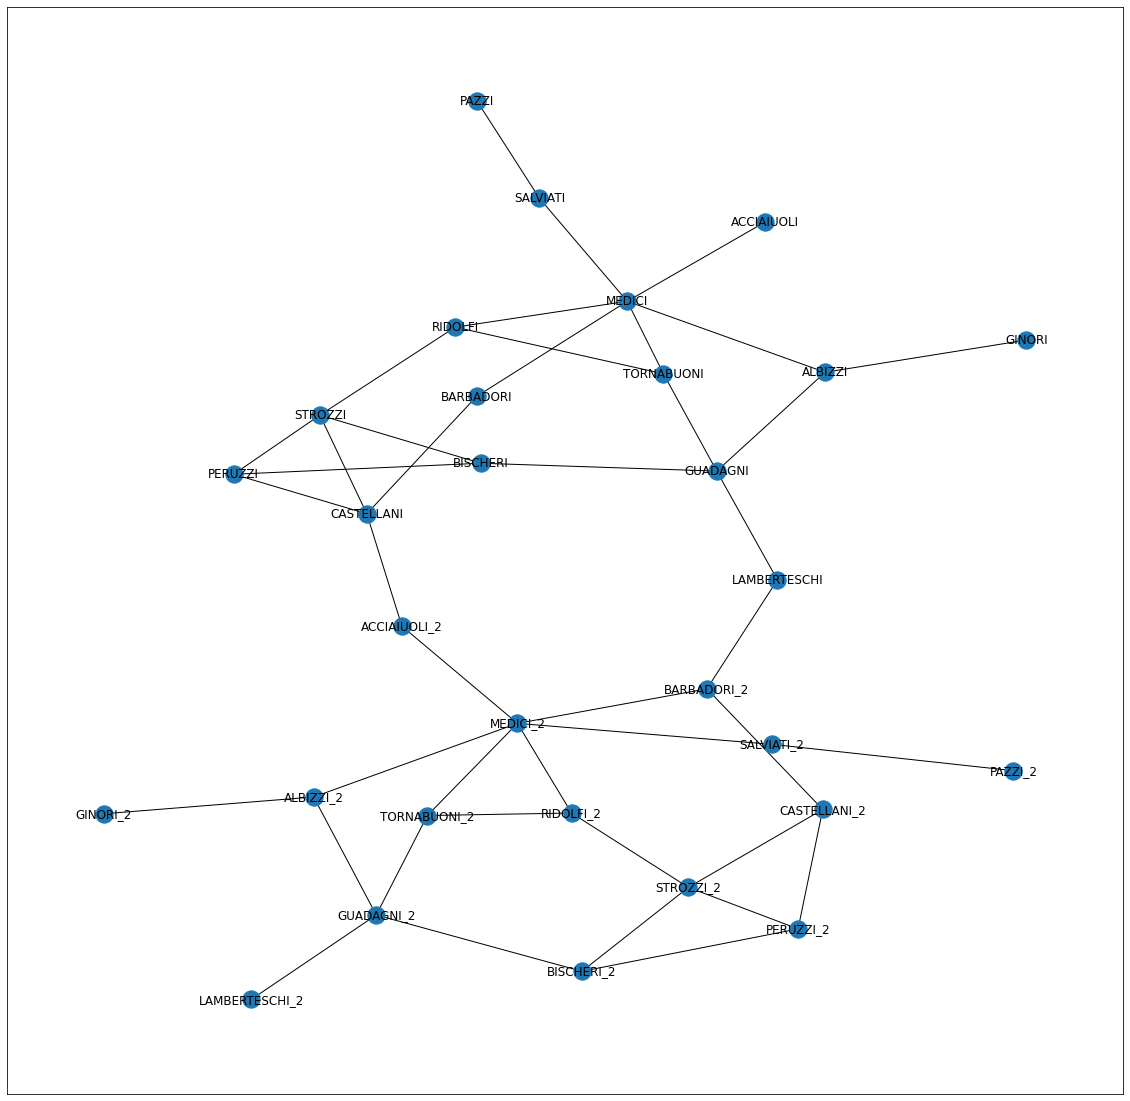

In [163]:
### Un premier affichage (ne marche que avec peu de sommets)

# l'algorithme cherche la meilleure position des somments
# si on exécute plurieurs fois l'apparence peut changer
pos = nx.kamada_kawai_layout(SG0)
plt.figure(figsize = (20,20))
nx.draw_networkx(SG0, pos)

## Explorer les relations entre propriétés structurales (centralités) et/ou attributs

### Relations entre deux centralités

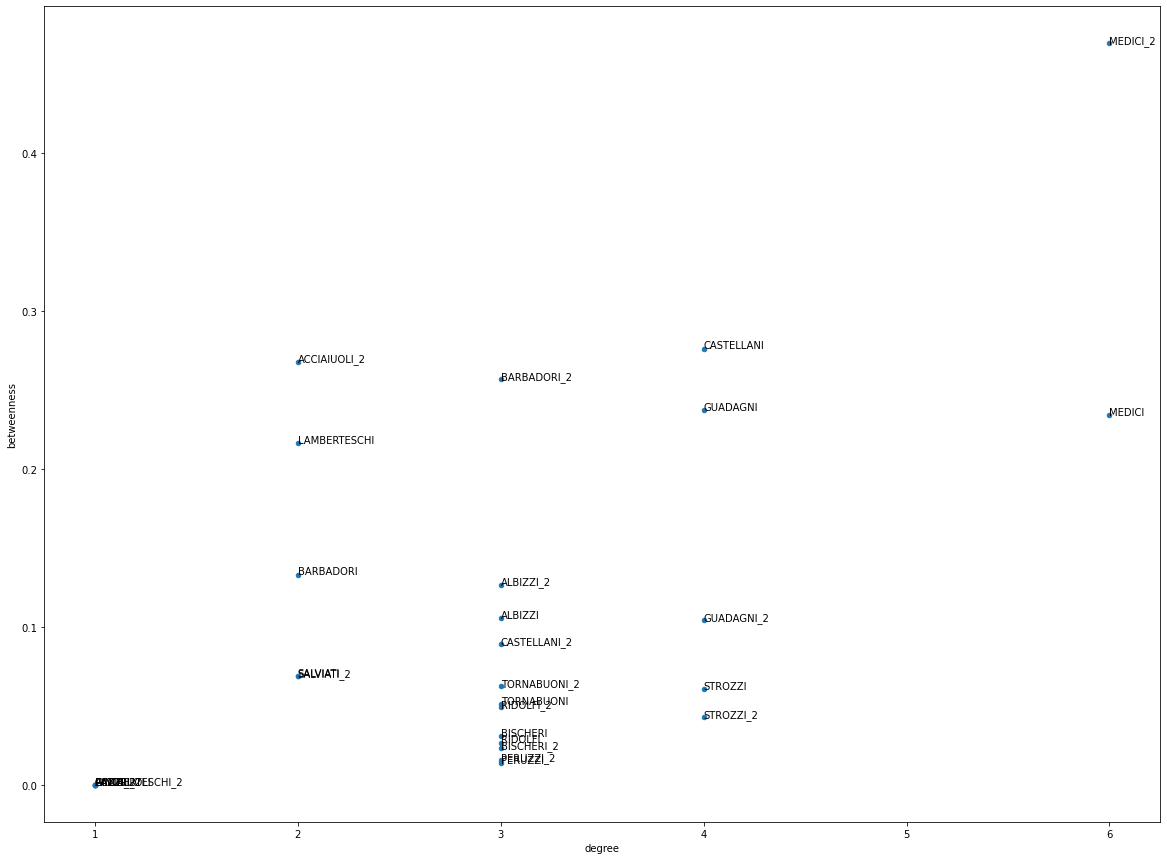

In [164]:
export_SG0[['degree','betweenness']].plot(x = 'degree', y = 'betweenness',kind='scatter',figsize=(20,15))
for i,row in list(export_SG0[['degree','betweenness']].iterrows()):
    plt.annotate(i,(row['degree'], row['betweenness']))

# Cohésion et cliques

In [165]:
nx.is_connected(SG0), nx.density(SG0)

(True, 0.09655172413793103)

In [166]:
### Returns all maximal cliques in an undirected graph.
# https://networkx.org/documentation/stable/reference/algorithms/clique.html?highlight=cliques

[list(nx.find_cliques(SG0))]

[[['MEDICI_2', 'ALBIZZI_2'],
  ['MEDICI_2', 'BARBADORI_2'],
  ['MEDICI_2', 'SALVIATI_2'],
  ['MEDICI_2', 'RIDOLFI_2', 'TORNABUONI_2'],
  ['MEDICI_2', 'ACCIAIUOLI_2'],
  ['GUADAGNI', 'LAMBERTESCHI'],
  ['GUADAGNI', 'ALBIZZI'],
  ['GUADAGNI', 'TORNABUONI'],
  ['GUADAGNI', 'BISCHERI'],
  ['TORNABUONI', 'MEDICI', 'RIDOLFI'],
  ['ACCIAIUOLI', 'MEDICI'],
  ['PERUZZI_2', 'STROZZI_2', 'CASTELLANI_2'],
  ['PERUZZI_2', 'STROZZI_2', 'BISCHERI_2'],
  ['RIDOLFI', 'STROZZI'],
  ['BISCHERI', 'STROZZI', 'PERUZZI'],
  ['LAMBERTESCHI', 'BARBADORI_2'],
  ['MEDICI', 'BARBADORI'],
  ['MEDICI', 'ALBIZZI'],
  ['MEDICI', 'SALVIATI'],
  ['STROZZI', 'CASTELLANI', 'PERUZZI'],
  ['ALBIZZI', 'GINORI'],
  ['LAMBERTESCHI_2', 'GUADAGNI_2'],
  ['CASTELLANI_2', 'BARBADORI_2'],
  ['GINORI_2', 'ALBIZZI_2'],
  ['BISCHERI_2', 'GUADAGNI_2'],
  ['PAZZI', 'SALVIATI'],
  ['STROZZI_2', 'RIDOLFI_2'],
  ['GUADAGNI_2', 'ALBIZZI_2'],
  ['GUADAGNI_2', 'TORNABUONI_2'],
  ['CASTELLANI', 'BARBADORI'],
  ['CASTELLANI', 'ACCIAIUOLI_2'],


In [167]:
[c for c in list(nx.find_cliques(SG0)) if len(c) > 2]

[['MEDICI_2', 'RIDOLFI_2', 'TORNABUONI_2'],
 ['TORNABUONI', 'MEDICI', 'RIDOLFI'],
 ['PERUZZI_2', 'STROZZI_2', 'CASTELLANI_2'],
 ['PERUZZI_2', 'STROZZI_2', 'BISCHERI_2'],
 ['BISCHERI', 'STROZZI', 'PERUZZI'],
 ['STROZZI', 'CASTELLANI', 'PERUZZI']]

In [168]:
### https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.kcomponents.k_components.html#networkx.algorithms.connectivity.kcomponents.k_components
nx.k_components(SG0)

{2: [{'ACCIAIUOLI_2',
   'ALBIZZI',
   'ALBIZZI_2',
   'BARBADORI',
   'BARBADORI_2',
   'BISCHERI',
   'BISCHERI_2',
   'CASTELLANI',
   'CASTELLANI_2',
   'GUADAGNI',
   'GUADAGNI_2',
   'LAMBERTESCHI',
   'MEDICI',
   'MEDICI_2',
   'PERUZZI',
   'PERUZZI_2',
   'RIDOLFI',
   'RIDOLFI_2',
   'STROZZI',
   'STROZZI_2',
   'TORNABUONI',
   'TORNABUONI_2'}],
 1: [{'ACCIAIUOLI',
   'ACCIAIUOLI_2',
   'ALBIZZI',
   'ALBIZZI_2',
   'BARBADORI',
   'BARBADORI_2',
   'BISCHERI',
   'BISCHERI_2',
   'CASTELLANI',
   'CASTELLANI_2',
   'GINORI',
   'GINORI_2',
   'GUADAGNI',
   'GUADAGNI_2',
   'LAMBERTESCHI',
   'LAMBERTESCHI_2',
   'MEDICI',
   'MEDICI_2',
   'PAZZI',
   'PAZZI_2',
   'PERUZZI',
   'PERUZZI_2',
   'RIDOLFI',
   'RIDOLFI_2',
   'SALVIATI',
   'SALVIATI_2',
   'STROZZI',
   'STROZZI_2',
   'TORNABUONI',
   'TORNABUONI_2'}]}

In [169]:
###https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.kcomponents.k_components.html?highlight=k_components#networkx.algorithms.approximation.kcomponents.k_components

from networkx.algorithms import approximation as apxa
apxa.k_components(SG0, min_density = 0.1)

defaultdict(list,
            {1: [{'ACCIAIUOLI',
               'ACCIAIUOLI_2',
               'ALBIZZI',
               'ALBIZZI_2',
               'BARBADORI',
               'BARBADORI_2',
               'BISCHERI',
               'BISCHERI_2',
               'CASTELLANI',
               'CASTELLANI_2',
               'GINORI',
               'GINORI_2',
               'GUADAGNI',
               'GUADAGNI_2',
               'LAMBERTESCHI',
               'LAMBERTESCHI_2',
               'MEDICI',
               'MEDICI_2',
               'PAZZI',
               'PAZZI_2',
               'PERUZZI',
               'PERUZZI_2',
               'RIDOLFI',
               'RIDOLFI_2',
               'SALVIATI',
               'SALVIATI_2',
               'STROZZI',
               'STROZZI_2',
               'TORNABUONI',
               'TORNABUONI_2'}],
             2: [{'ACCIAIUOLI_2',
               'ALBIZZI',
               'ALBIZZI_2',
               'BARBADORI',
               'BARBA

In [170]:
kG = nx.k_core(SG0, k=2)
nx.info(kG)

'Graph with 22 nodes and 34 edges'

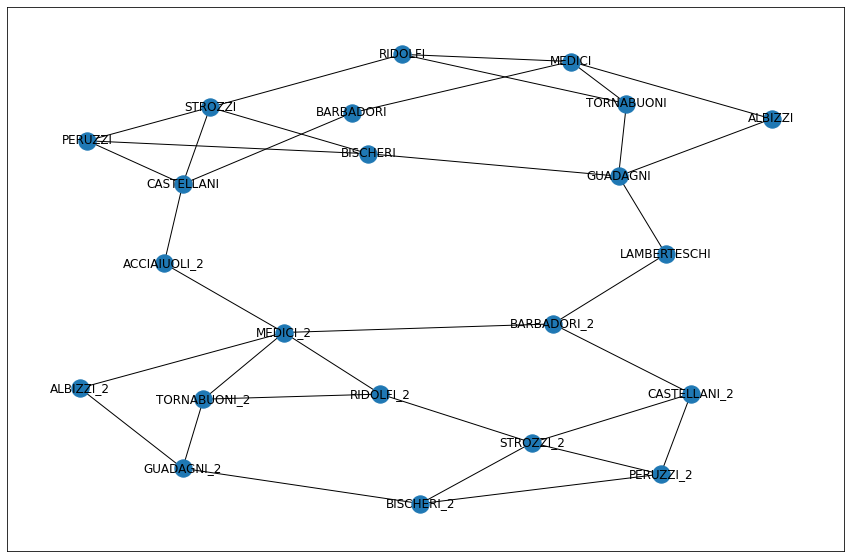

In [171]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,10))

#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(kG)

nx.draw_networkx(kG, pos)
